In [1]:

import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import scipy.signal as ssi
import statsmodels as smo
from scipy.fft import fft, fftfreq

from keras.utils import np_utils

import random

In [262]:
#### file splitter, div entre test/val/train
def file_splitter_train_test_val(fullsetfile,spltDct={"val":20.0, "test":10.0}):
    ### permite dividir en test/train o test/val/train
    nontrain=0.0
    for key,val in spltDct.items():
        nontrain+=val
    #spltDct["train"]=100.0-nontrain
    
    #fullset=pd.read_csv(fullsetfile)
    fullset=np.loadtxt(fullsetfile ,delimiter=";")
    ## shuffle
    rng=np.random.default_rng()
    rng.shuffle(fullset,axis=0)
    nline,ncols=np.shape(fullset)
    print("Balance en origen: ",np.sum(fullset[:,-1]))
    print("nline,ncols",nline,ncols)
    #ifull=np.arange(nline)
    #random.shuffle(ifull)
    
    #FileDct={}
    nsub=0
    n0=0
    for key,val in spltDct.items():
        nsub+=int(val/100.0*nline)
        print("n0,nsub",n0,nsub)
        subset=fullset[n0:nsub,:]
        n0=nsub
        print("Balance subset: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
        np.savetxt(key+"_"+fullsetfile,subset,delimiter=";",fmt="%d")
        #FileDct[key]=key+fullsetfile
        #fwrite=open(file=key+fullsetfile,"w")
    subset=fullset[n0:,:]
    print("remanente:", np.shape(subset))
    print("Balance rem: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
    np.savetxt("train"+"_"+fullsetfile,subset,delimiter=";")
    

#file_splitter_train_test_val("../DatosOriginales/SpO2seg.csv")


Balance en origen:  1926.0
nline,ncols 4208 961
n0,nsub 0 841
Balance subset:  0.450653983353151
n0,nsub 841 1261
Balance subset:  0.4261904761904762
remanente: (2106, 961)
Balance rem:  0.44776828110161443


In [2]:
### Por ahora creamos los features

class featured_tseries_df():
    ### se levanta el set full, con sus labels
    
    
    def __init__(self,filename,downsample=1,timeft=True,freqft=True,\
                 renormMx=100.0,renormMn=0.0,augment=None,diff=0,renormRowsDct=None,selfRenorm=False):
        
        self.filename=filename
        self.tab0=np.loadtxt(self.filename,delimiter=";")
        self.df0=self.tab0[:,:-1].astype("float32")
        self.labeltab=np_utils.to_categorical( self.tab0[:,-1]).astype("float32")  #)## para keras
        self.labelvec=self.tab0[:,-1]#.astype(int)
        self.timeft=timeft
        self.freqft=freqft
        self.downsample=downsample
        
        
        
        self.renorm_01(renormMx,renormMn)
        #self.df0=self.df0
        #self.take_exp()
        #self.renorm_01(np.amax(self.df0) ,0.0)
    
        #self.renorm_01(renormMx,renormMn)
        #self.take_log10(0.0001)
        if selfRenorm==True:
            self.sigmas=np.std( self.df0 ,axis=0)
            self.sigma=np.std(self.sigmas)
            self.means=np.mean(self.df0,axis=0)
            self.mean=np.mean(self.means)
            self.df0=self.df0-self.mean###self.means[np.newaxis,:]
            self.df0=self.df0/self.sigma
        if isinstance(renormRowsDct,dict):
            #self.sigmas=np.std( self.df0 ,axis=0)
            #self.sigma=np.std(self)
            #self.means=np.mean(self.df0,axis=0)
            self.df0=self.df0-renormRowsDct["mean"]###self.means[np.newaxis,:]
            self.df0=self.df0/renormRowsDct["std"]
            #self.df0=self.df0-self.sigma[np.newaxis,:]
        
        if augment is not None:
            self.data_augmentation(augment,dct={"roll":7})
        
        
        self.df_downsample()
        
        self.nrows0,self.ncols0=np.shape(self.df0)
        self.nrows1,self.ncols1=np.shape(self.df1)
        
        print("Pre downsample :", np.shape(self.df0))
        print("Post downsample :", np.shape(self.df1))
        
        if diff!=0:
            for idiff in np.arange(1,diff):
                self.df1=np.gradient( self.df1, axis=0)
        
        IDs=np.random.randint(0,high=self.nrows0,size=5)
        self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
        self.plot_random_signals(self.df1,IDs,title="Post downsample",plotfilename="SpO2randomDSP.png" )
        self.plot_boxplots()
        self.df2=pd.DataFrame()
    
        if self.timeft==True:
            self.generate_timeft()
        if self.freqft==True:
            self.Fdf0=np.fft.fft(self.df0,axis=0)
            self.generate_freqft()
    
        #self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
            self.plot_random_signals(self.FAbsdf0,IDs,title="FFT Post downsample",plotfilename="FFTSpO2randomDSP.png",yscale=[0.0,10.0] )
        
        #self.df1=self.df1[:,:,np.newaxis]
        
    def data_augmentation(self,naug,dct):
        
        if "roll" in dct.keys():
            step0=dct["roll"]
            dfaux0=np.roll(self.df0,0,axis=0)
            lab0=self.labeltab
            vec0=self.labelvec
            for iaug in np.arange(naug):
                dfaux=np.roll(self.df0,step0*(iaug+1),axis=0)
                dfaux0=np.concatenate( (dfaux0,dfaux), axis=0)
                
                lab0=np.concatenate( (lab0,self.labeltab),axis=0)
                vec0=np.concatenate(  (vec0,self.labelvec),axis=0)
                
            self.df0=dfaux0 #np.concatenate( (self.df0,dfaux0), axis=0)
            self.labeltab=lab0    
            self.labelvec=vec0
    
    def generate_timeft(self):
        #### lost area 
        lostarea=np.sum(1.0-self.df1,axis=0)
        totarea=np.sum( np.ones_like(self.df1),axis=0)
        self.df2["lost_area"]=lostarea/totarea
        #### first derivative 
        self.df1D=np.gradient( self.df1, axis=0)
        firstder=np.sum (  np.abs(self.df1D  ) ,axis=0)
        self.df2["first_der"]=firstder /totarea
        #### secder
        self.df1D2=np.gradient( self.df1D, axis=0)
        secder=np.sum (  np.abs( self.df1D2 ) ,axis=0)
        self.df2["sec_der"]=secder /totarea
        ### amplitude 
        self.df2["amplitude"]=np.max(self.df1,axis=0)-np.min(self.df1,axis=0)
        
    def generate_freqft(self):
        
        ## freq = np.fft.fftfreq(tvec.shape[-1])*2.0*np.pi/ht/omegaIR_au
        FouD1=np.fft.fft(self.df1D,axis=0)
        self.FAbsdf0=np.abs(FouD1)**2 #np.fft.fft(self.df0,axis=0)
        self.FPhasdf0=np.angle(FouD1) ### son arrays 1D por cada entrada.
        self.df2["fou_max_avg"]=np.amax(self.FAbsdf0,axis=0)/np.average(self.FAbsdf0,axis=0)
        self.df2["fou_freqmax"]=np.argmax(self.FAbsdf0,axis=0)
        
    def df_downsample(self,imethod=1):
        if self.downsample==1:
            pass
            self.df1=self.df0
        else :
            if imethod==0:
                self.df0=self.df0[:,0::self.downsample]
            elif imethod == 1 : ### genera un suavizado
                nrow,ncol=np.shape(self.df0)
                ndown=ncol//self.downsample
                self.df1=np.zeros( (nrow,ndown),dtype=float)
                
                #aux1=np.zeros()
                for idown in np.arange(self.downsample):
                    self.df1+=self.df0[:,idown::self.downsample] ### sumamos los desplazados
                self.df1/=self.downsample  ### div por el nro de subsampling
                    
    def renorm_01(self,mx,mn): ### renorm the SpO2 signal to [0,1], no centering.
        #pass
        self.df0/=(mx-mn)
        
    def take_log10(self,eps):
        self.df0=np.log10(eps+self.df0)
    def take_exp(self):
        self.df0=np.exp(self.df0)

        
    ####smo.tsa.stattools.acf()
    def plot_random_signals(self,mydf,IDs,title=" ",plotfilename=" ",yscale=[0.75,1.0]):

        nplot=len(IDs)
        linestyle_str = ["-",":","--","-."]
        linewidth=[4]
        linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
        nwidths=len(linewidth)
        nstyles=len(linestyle_str)
        ncolor=len(linecol)
        
        
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle(title)
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('$i_t$ ', fontsize = 35)
        ax1.set_ylabel('SpO2 signal', fontsize = 35)
        ax4.set_xlabel('$i_t$ ', fontsize = 35)
        ax4.set_ylabel('SpO2 signal', fontsize = 35)        #ax2 = ax1.twiny()

        ax1.tick_params("both",labelsize=24)

        for iplt in IDs:
            ax1.plot(mydf[iplt,:],lw=linewidth[iplt%nwidths],linestyle=linestyle_str[iplt%nstyles],\
                     color=linecol[iplt%ncolor])#,marker="X",ms=12,label="Retrieved")
        #plt.tricontourf(spec[:,0],spec[:,1],spec[:,2], 50,cmap=cmpalette)

        if plotfilename !=" ":
            plt.savefig(plotfilename,bbox_inches='tight', transparent=False)
        
    def plot_boxplots(self):
        print("Balanced?")
        print(np.sum(self.labelvec)/np.shape(self.labelvec)[0])
        print( np.sum(self.labeltab,axis=0 ) )
        for col in self.df1:
            #DBbox=[]#{}#[]
            #for ilev, lev in enumerate(Levs):
            #    DBbox.append( DBNum[col].loc[DBTarg[TargVar]==lev])
            #    #DBbox[ilev]= DBNum[col].loc[DBTarg[TargVar]==lev]
            pass

            #print(col)
            #NumBox=plt.boxplot(self.df1[col] ,notch=True,patch_artist=True,\
            #    labels=self.labelvec)
            #NumBox.set_title(col)
            #plt.show()#NumBox.show()
#class tseries_full():
    
#    def __init__(self,filename,downsample=1,freqft=True,splitTrainValTest=2,renormMx=100.0,renormMn=0.0):
        
#        self.filename=filename
#        self.tab0=np.loadtxt(self.filename,delimiter=";")
#        self.df0=self.tab0[:,:-1]
#        self.labeltab=self.tab0[:,-1]
#        self.timeft=timeft
#        self.freqft=freqft
#        self.downsample=downsample
        
        
#        self.renorm_01(renormMx,renormMn)
#        self.df_downsample()
#        print("Pre downsample :", np.shape(self.df0))
#        print("Post downsample :", np.shape(self.df1))

In [4]:
class TimeSeriesBundle():
    def __init__(self,name,TrainTSfile,ValTSfile,TestTSfile,downsample=1,augment=None,diff=0,RenormRows=False):

        self.name=name
        self.TrainTSfile=TrainTSfile
        self.ValTSfile=ValTSfile
        self.TestTSfile=TestTSfile
        #self.sizetuple=sizetuple
        self.downsample=downsample
        self.augment=augment
        self.diff=diff
        self.RenormRows=RenormRows
        print(" ---------- Train -------------------- ")
        self.Train=featured_tseries_df(self.TrainTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=1000.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct=None,selfRenorm=True)  
        print(" ---------- Val -------------------- ")
        self.Val=featured_tseries_df(self.ValTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=1000.0,renormMn=0.0,augment=self.augment,diff=diff,\
                            renormRowsDct={"mean":self.Train.mean,"std":self.Train.sigma})
        print(" ---------- Test -------------------- ")
        self.Test=featured_tseries_df(self.TestTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=1000.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct={"mean":self.Train.mean,"std":self.Train.sigma})
        #featured_tseries_df()
        ### se levanta el set full, con sus labels
    
    
    

 ---------- Train -------------------- 
Pre downsample : (5894, 960)
Post downsample : (5894, 960)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 960)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Test -------------------- 
Pre downsample : (840, 960)
Post downsample : (840, 960)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Train -------------------- 
Pre downsample : (5894, 960)
Post downsample : (5894, 480)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 480)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Test -------------------- 
Pre downsample : (840, 960)
Post downsample : (840, 480)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]
 ---------- Train -------------------- 


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (5894, 960)
Post downsample : (5894, 240)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-2-e1d4454817b2>:158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 240)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]
 ---------- Test -------------------- 


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (840, 960)
Post downsample : (840, 240)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]
 ---------- Train -------------------- 


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (5894, 960)
Post downsample : (5894, 120)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 120)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]
 ---------- Test -------------------- 


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (840, 960)
Post downsample : (840, 120)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]
 ---------- Train -------------------- 


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (5894, 960)
Post downsample : (5894, 60)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 60)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]
 ---------- Test -------------------- 


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Pre downsample : (840, 960)
Post downsample : (840, 60)


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]


<ipython-input-2-e1d4454817b2>:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


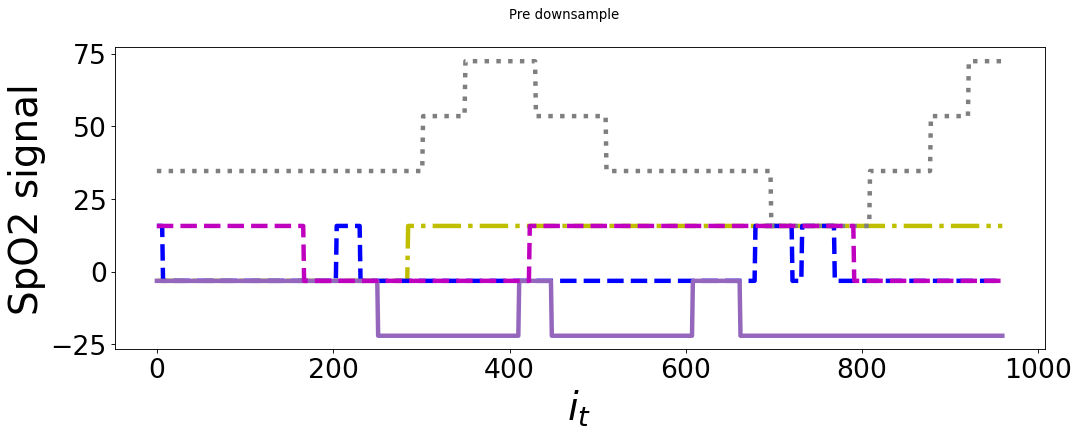

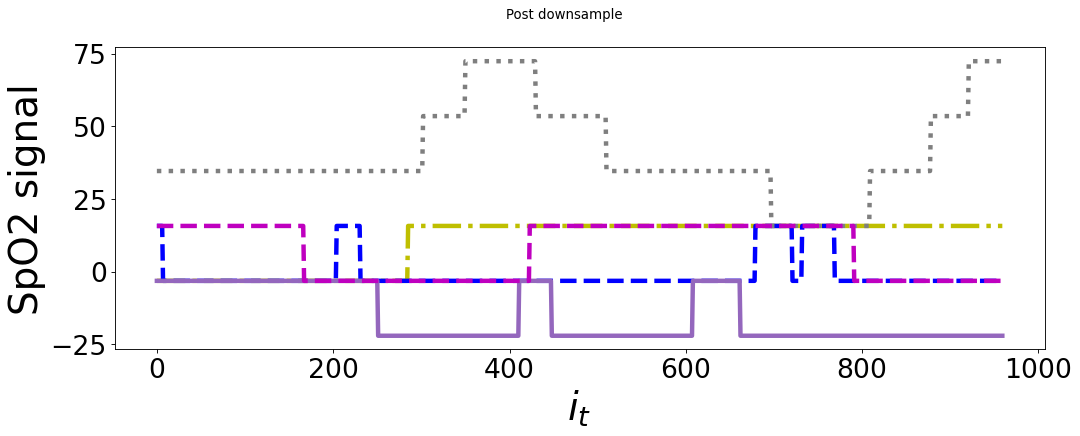

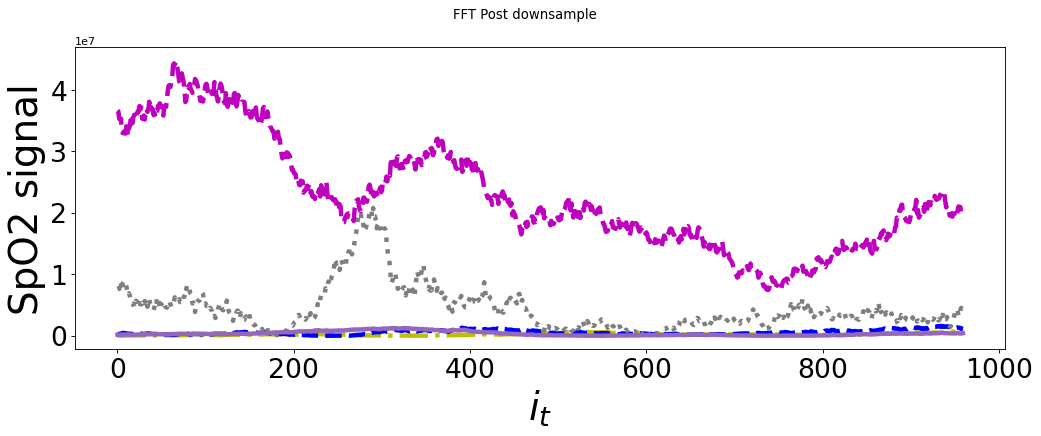

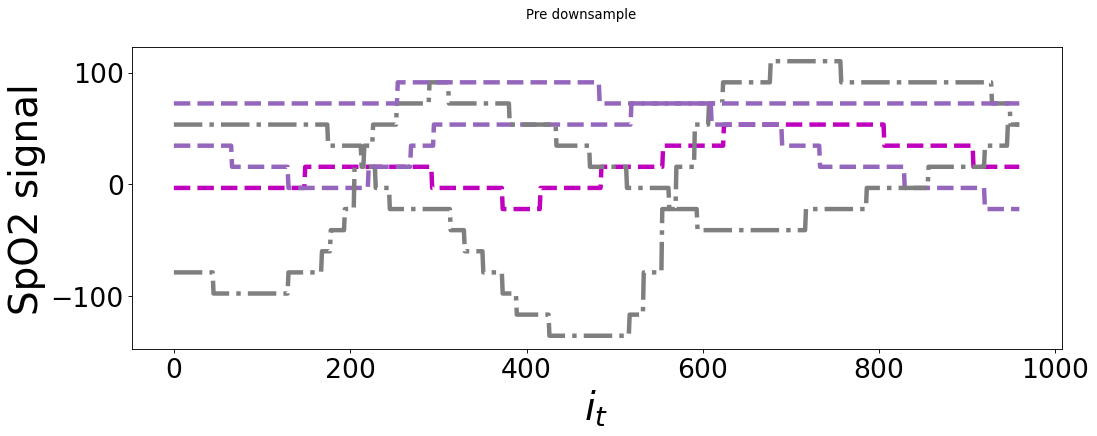

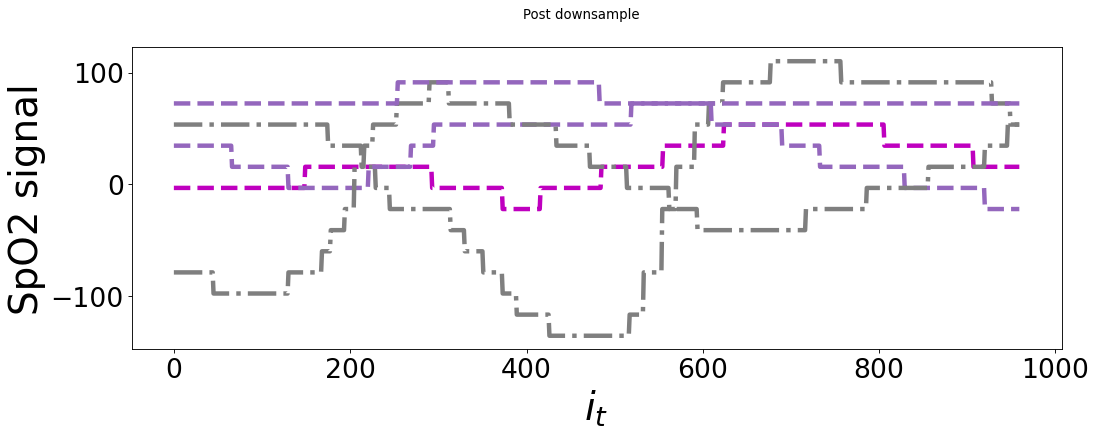

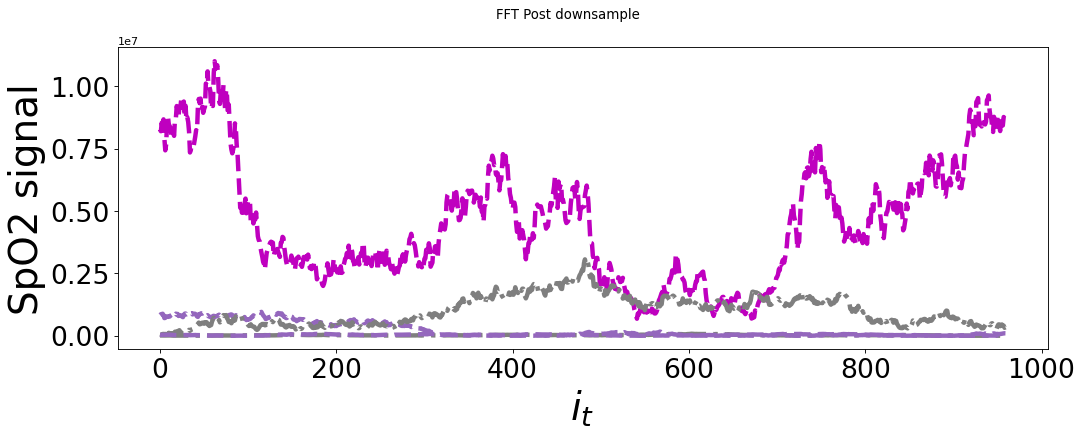

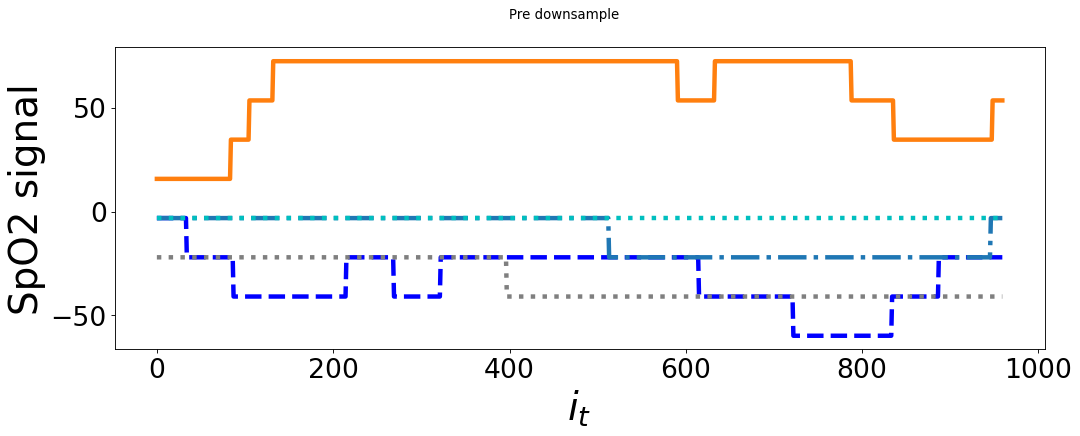

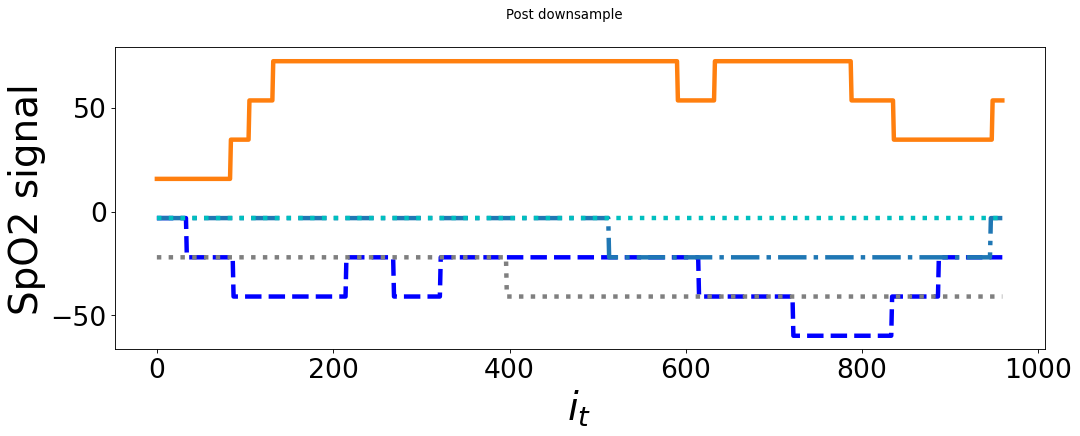

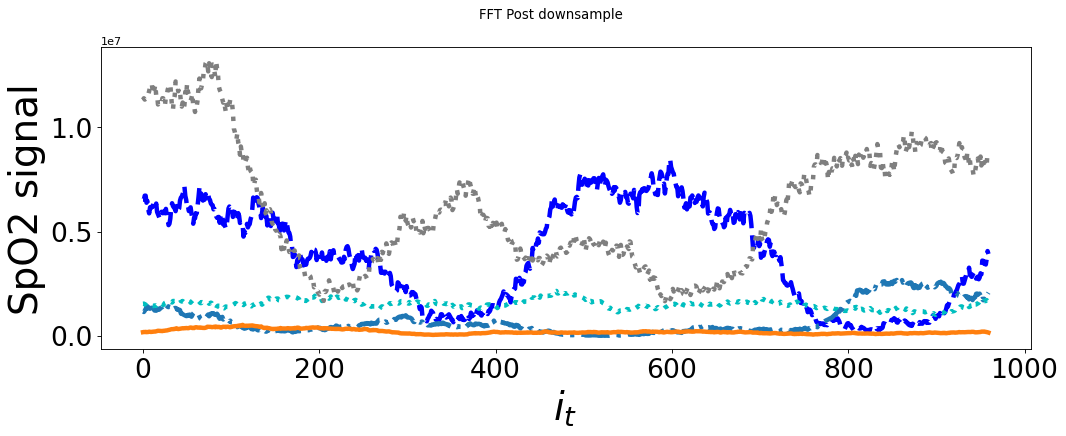

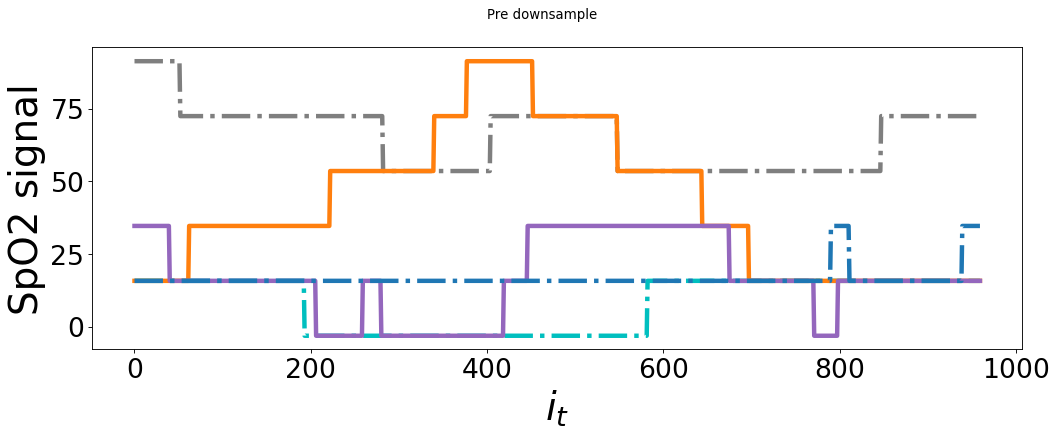

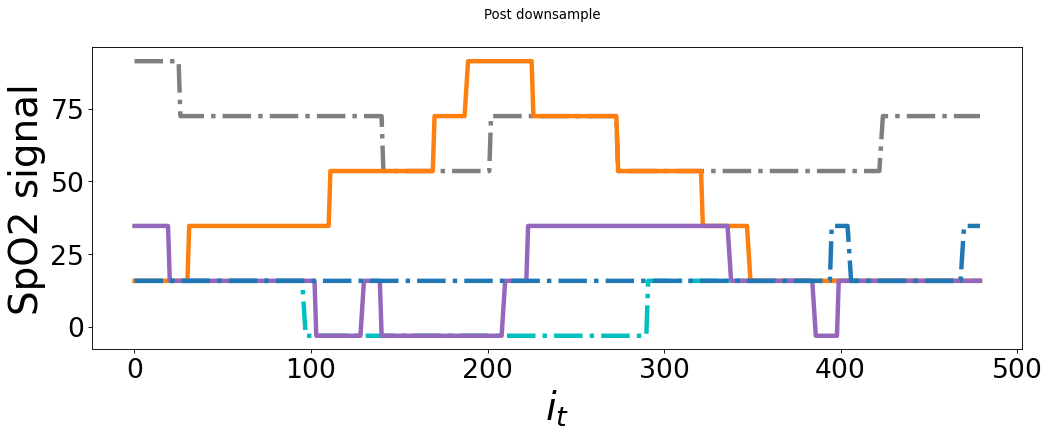

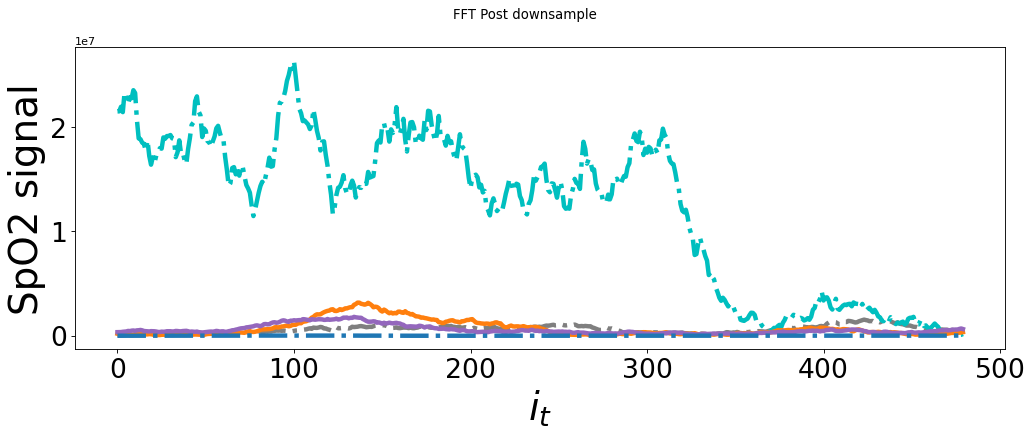

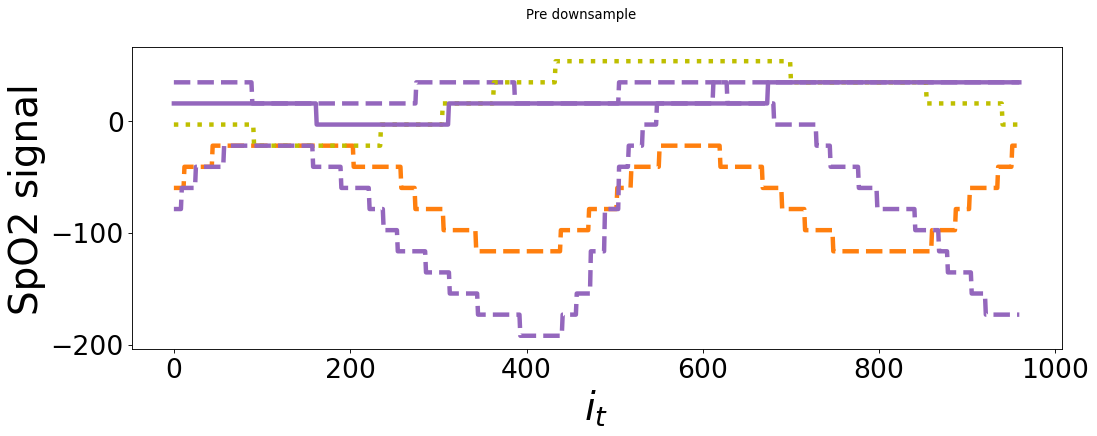

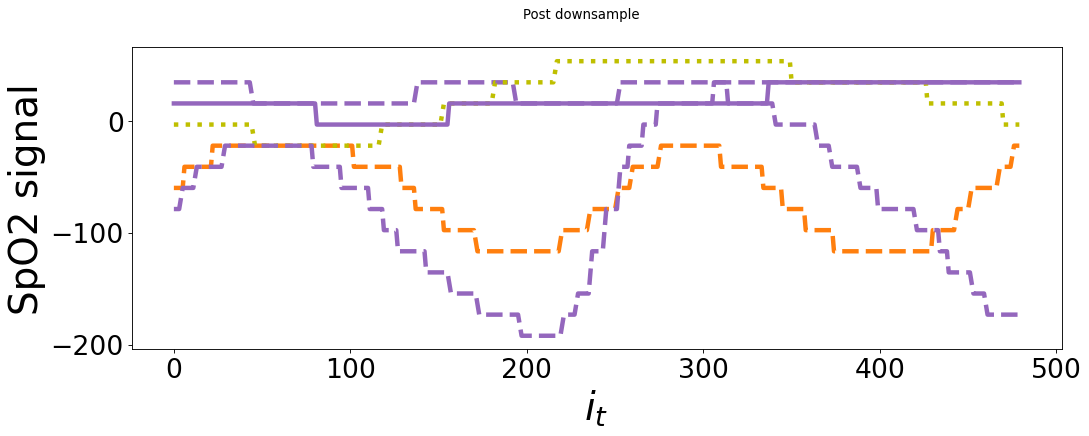

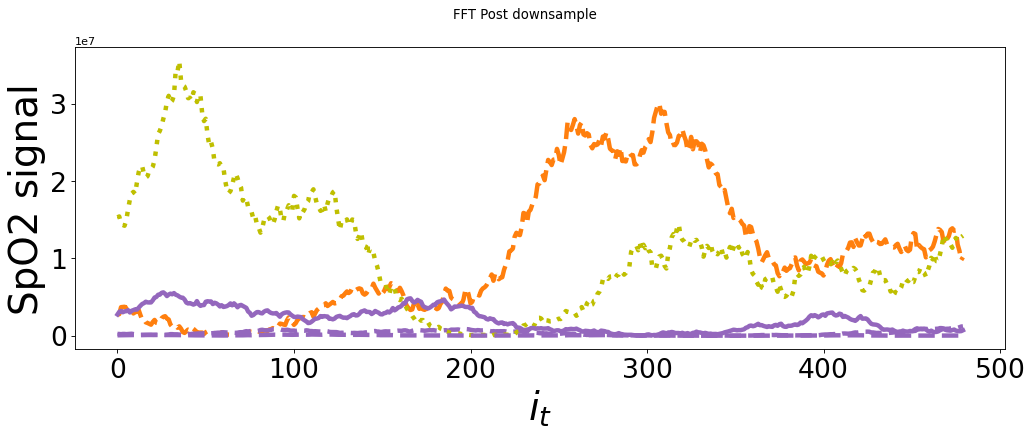

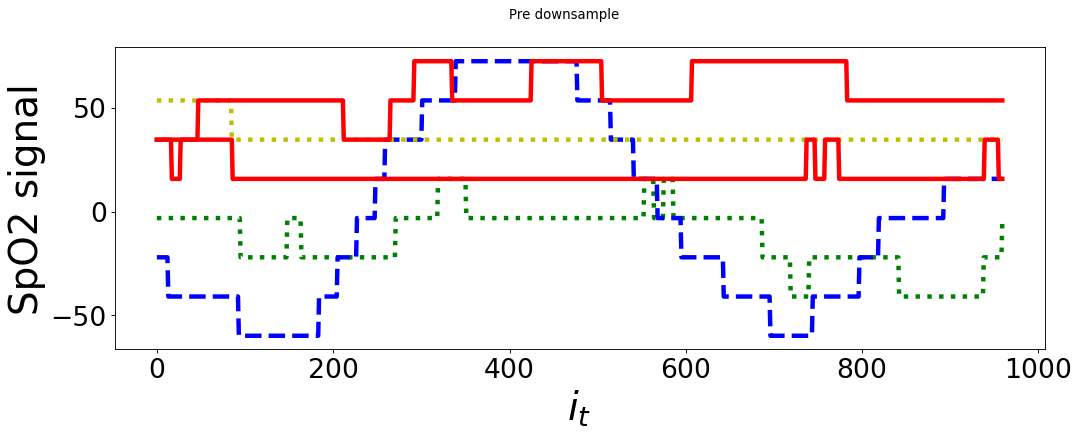

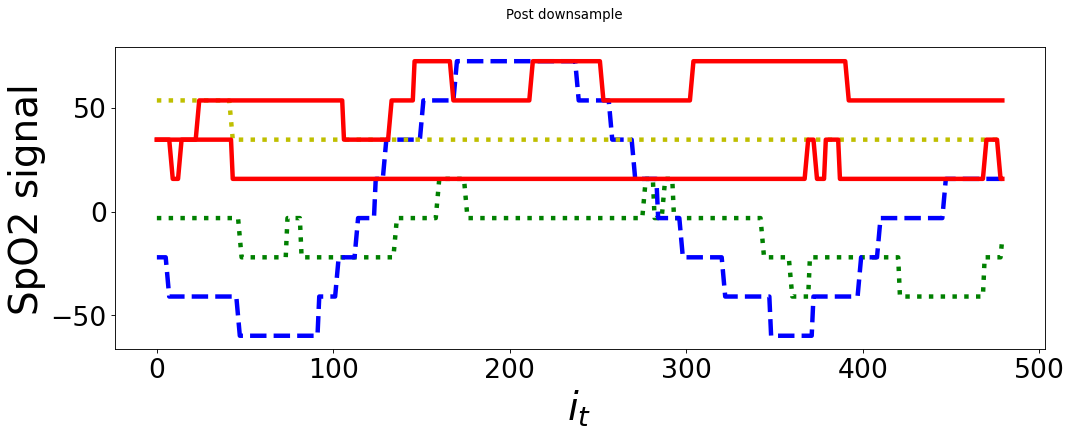

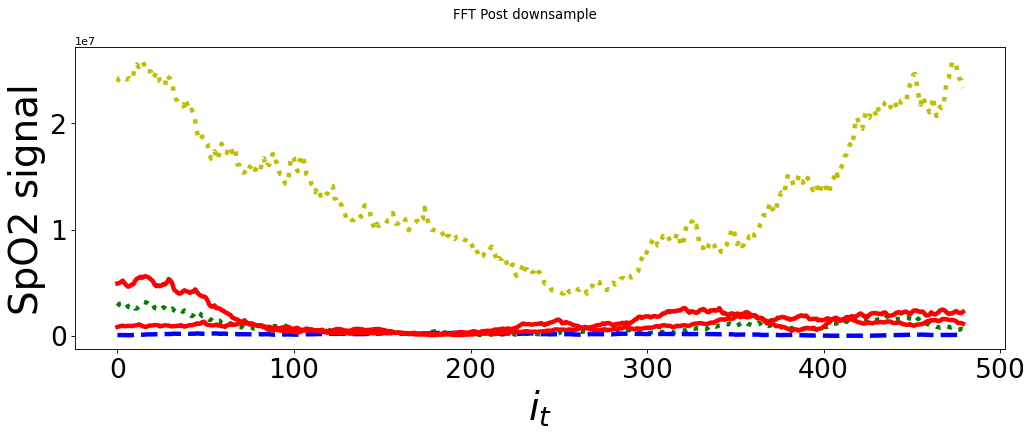

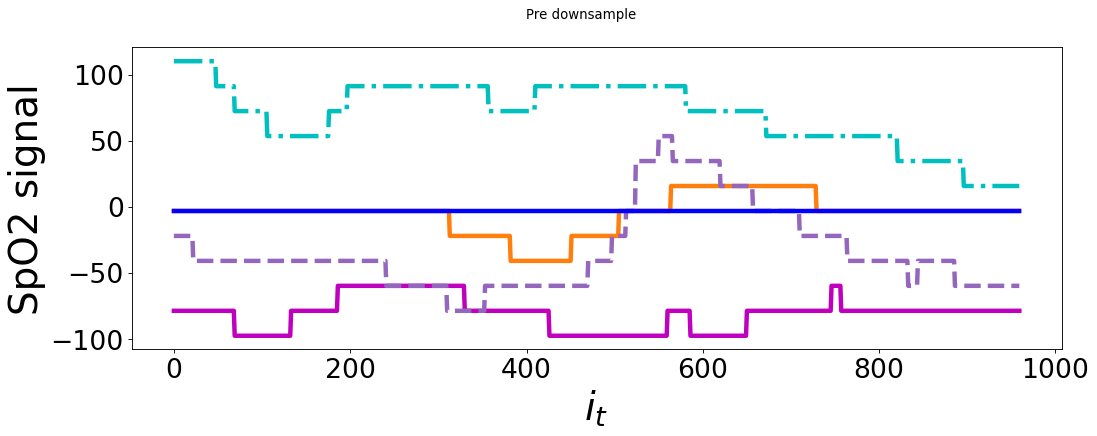

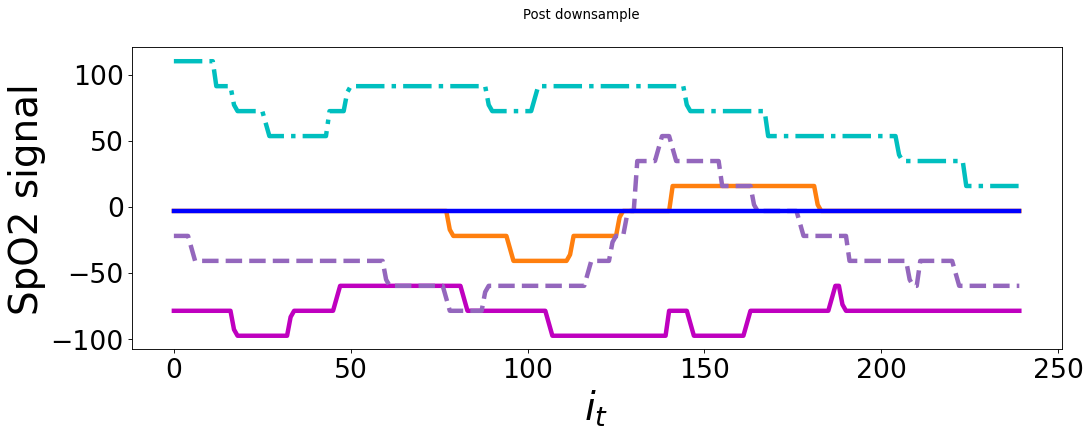

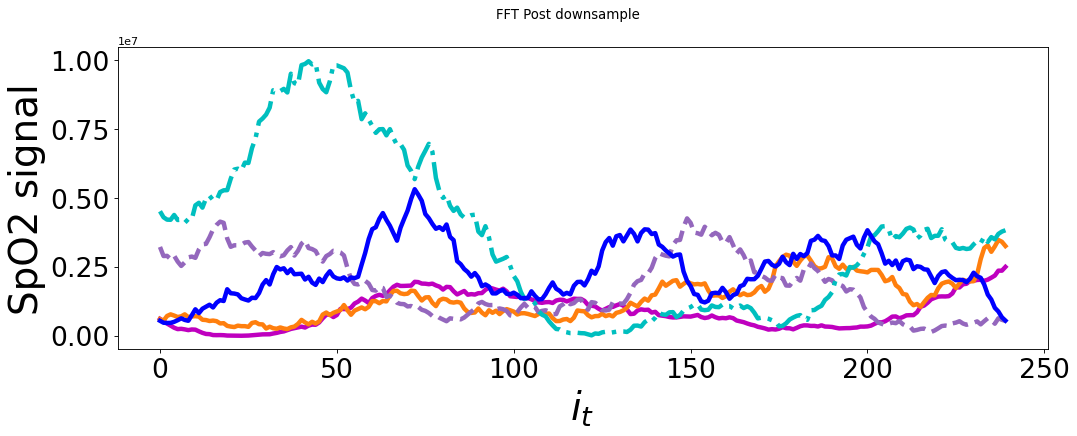

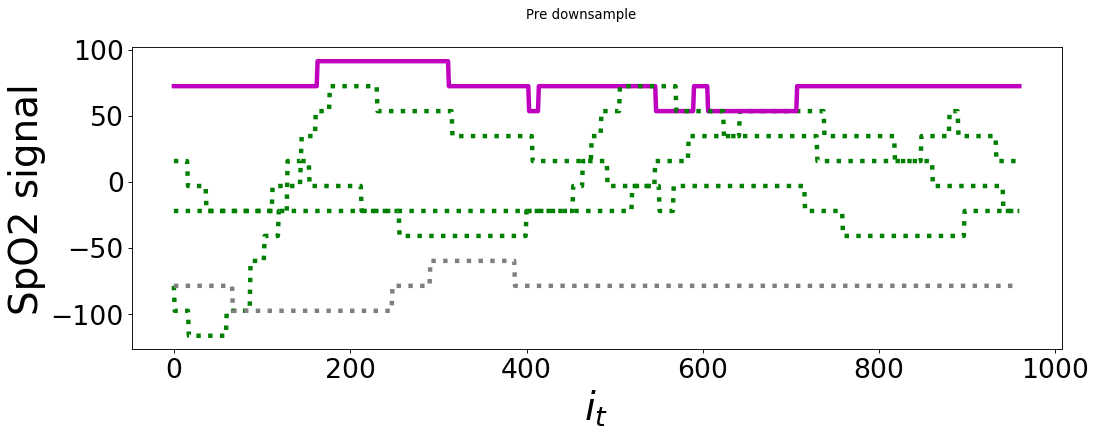

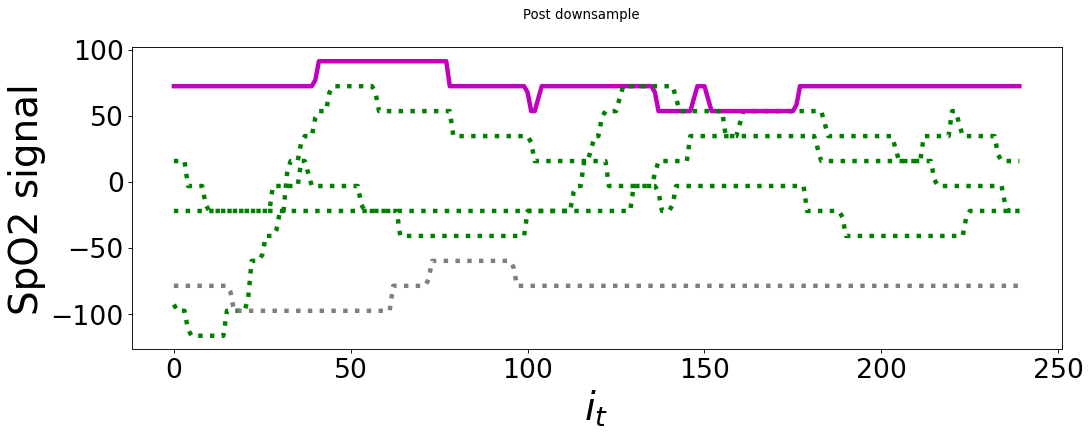

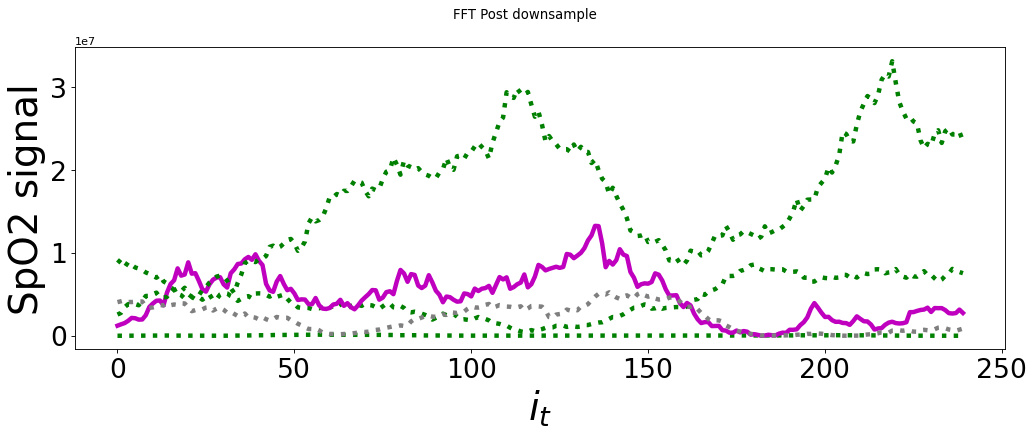

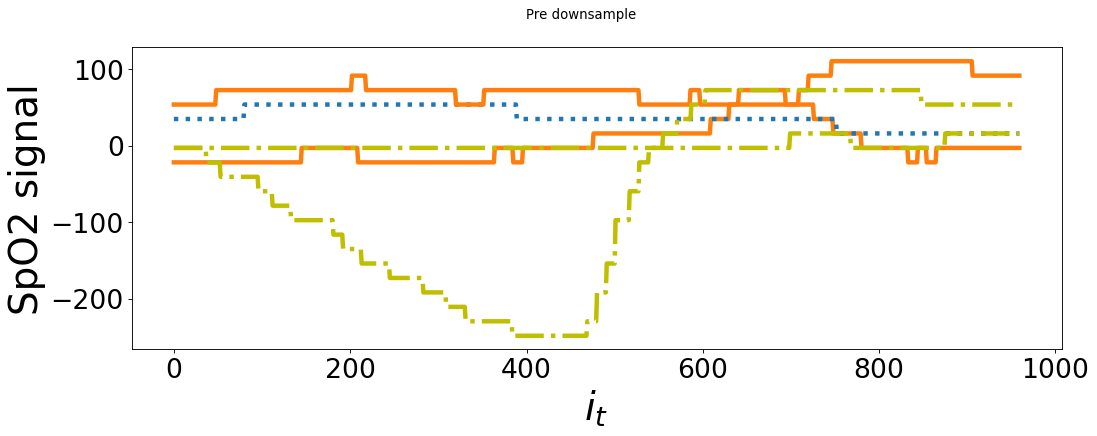

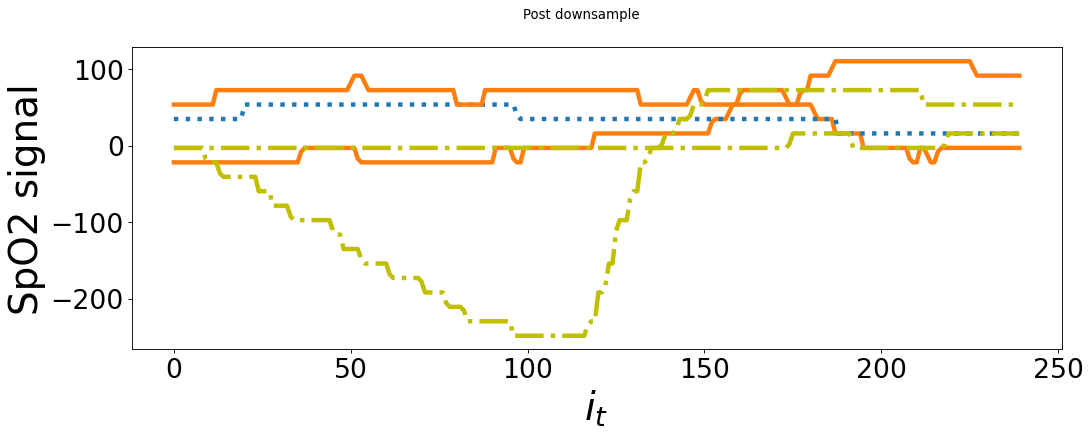

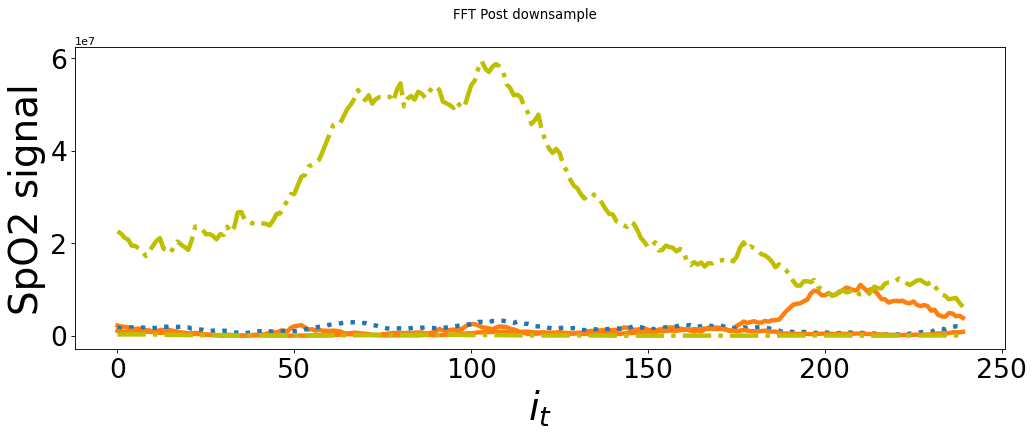

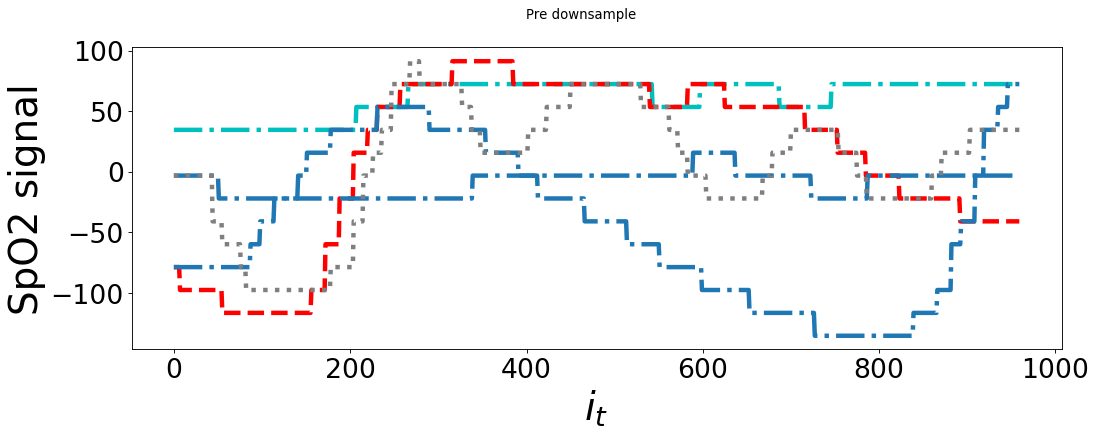

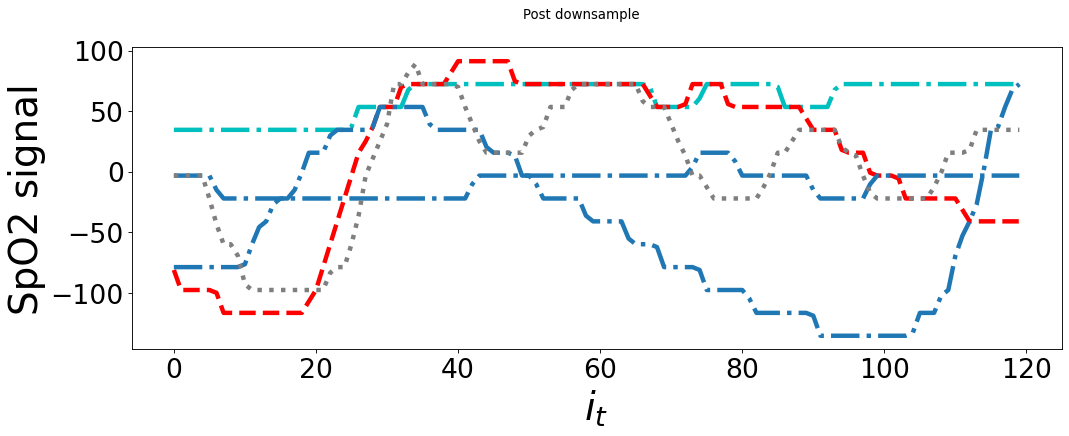

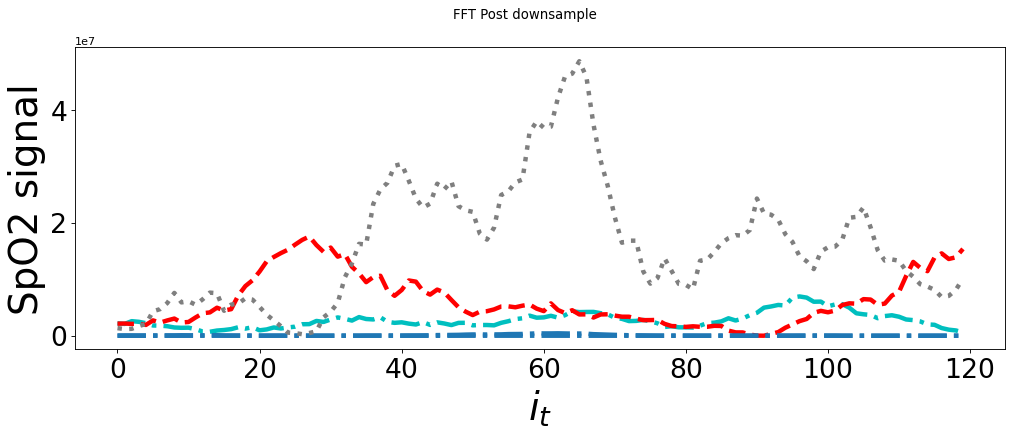

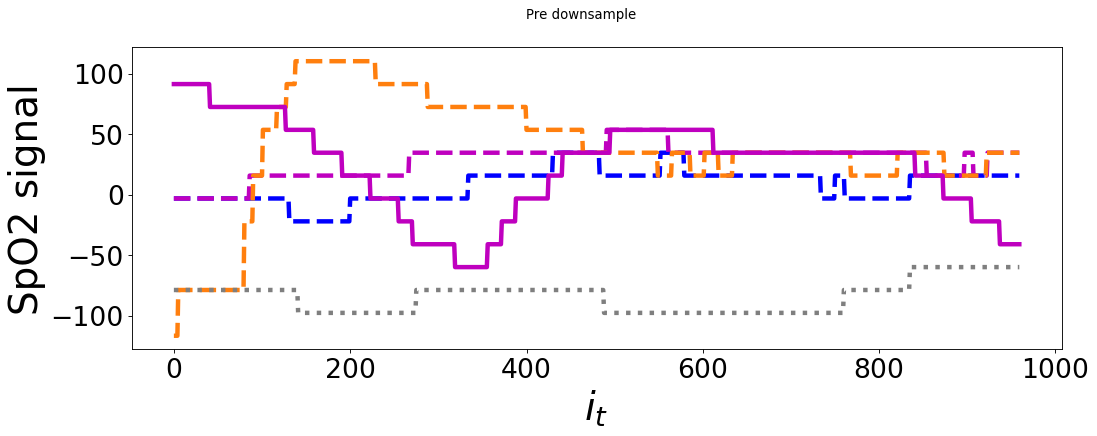

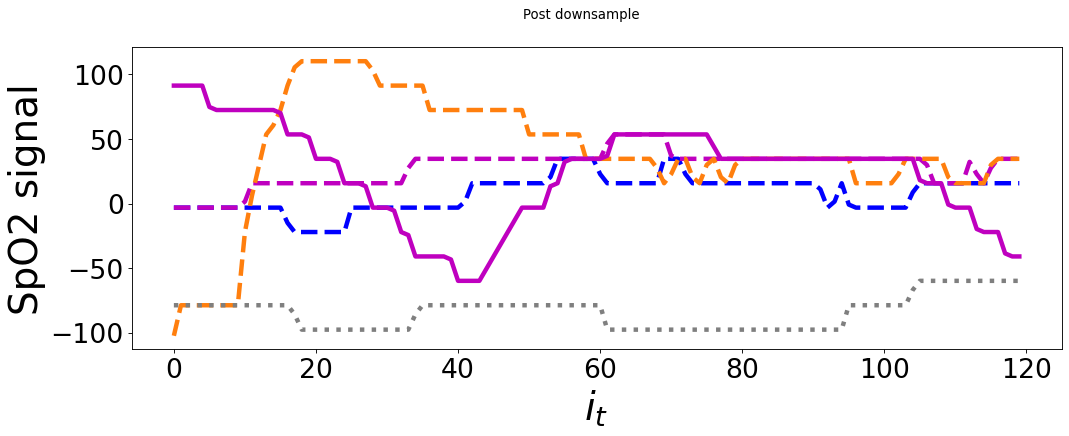

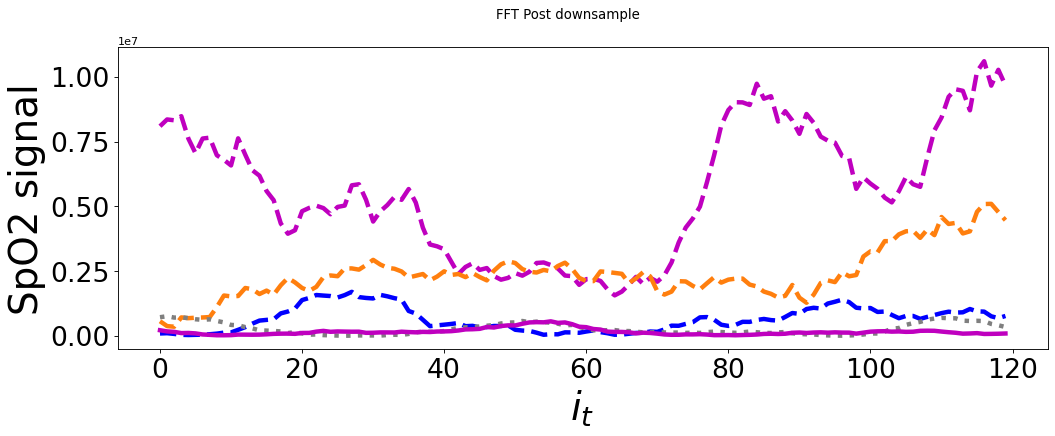

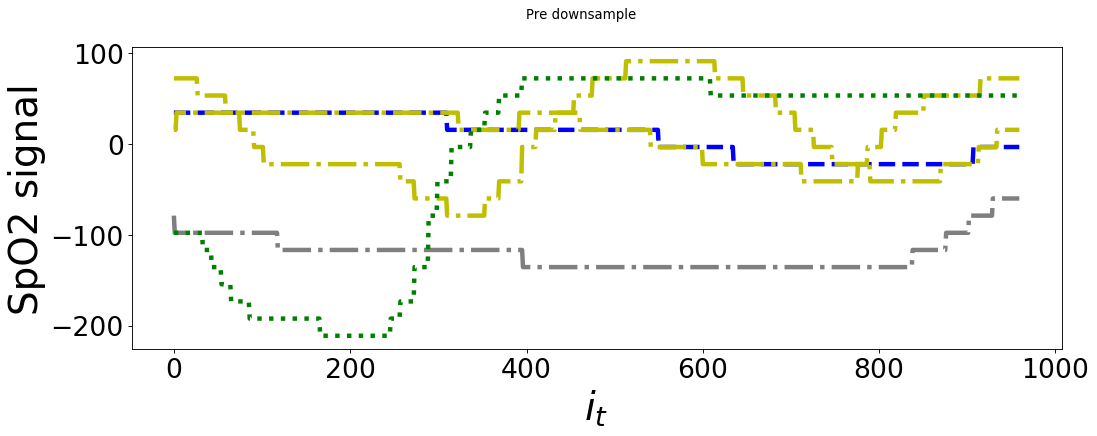

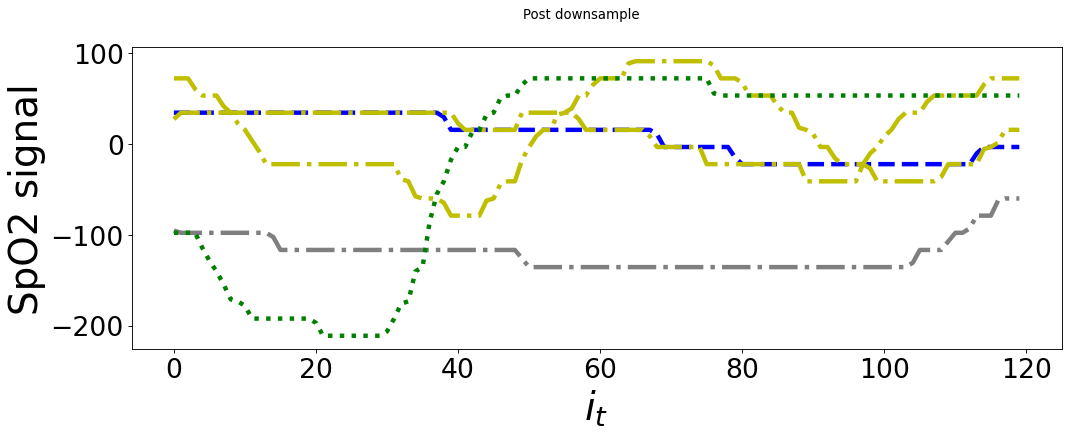

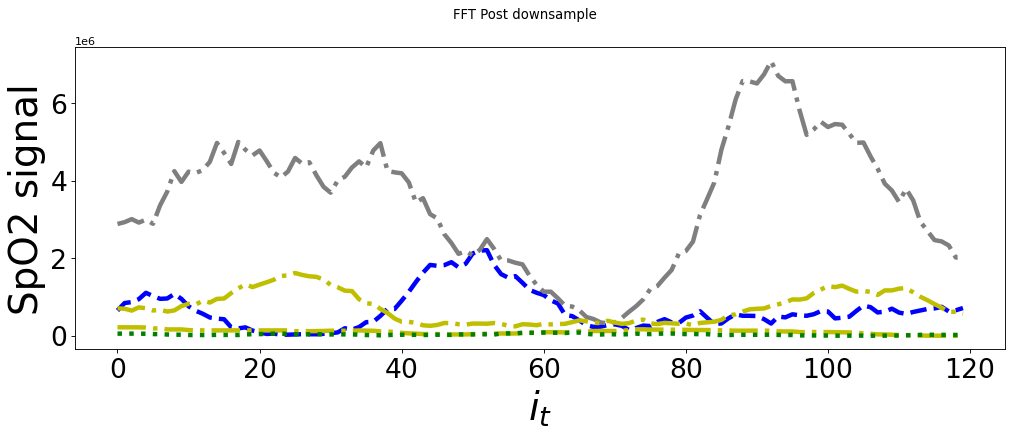

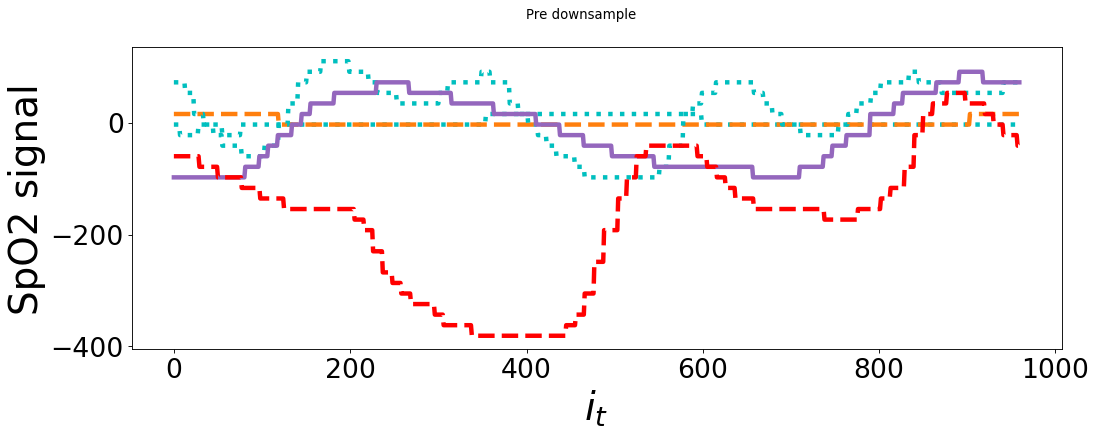

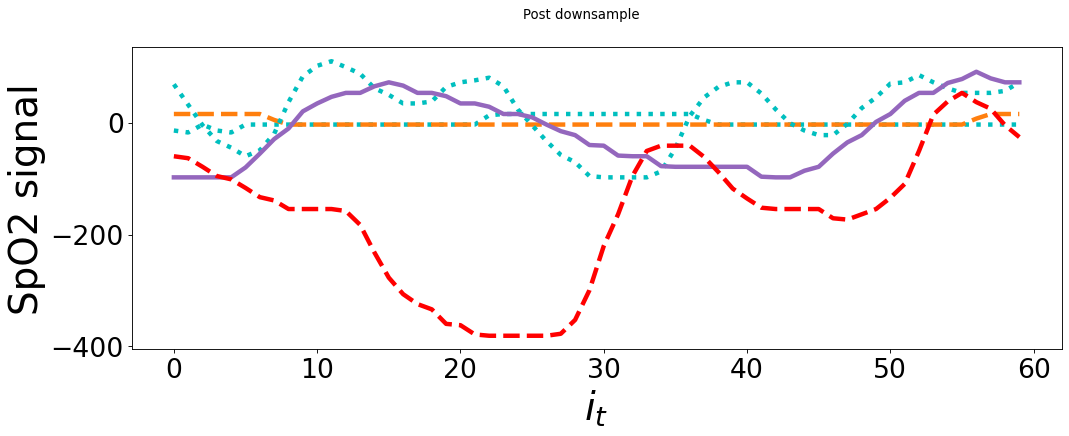

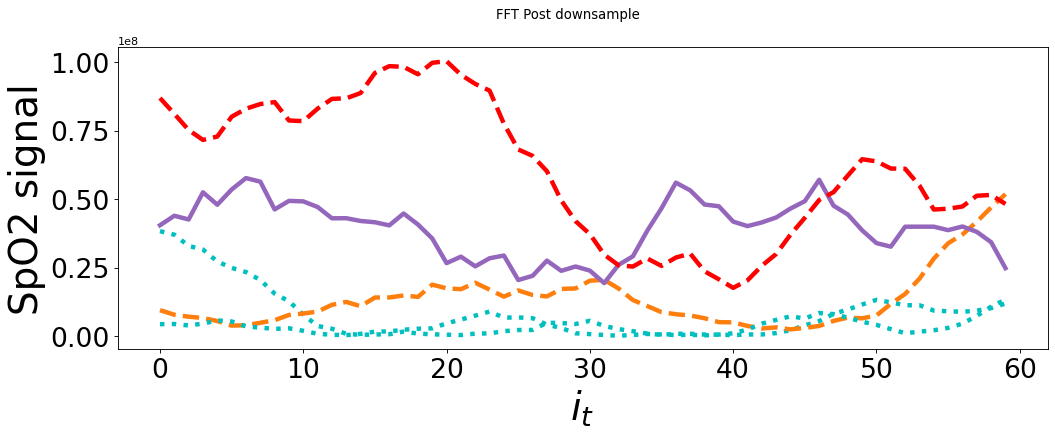

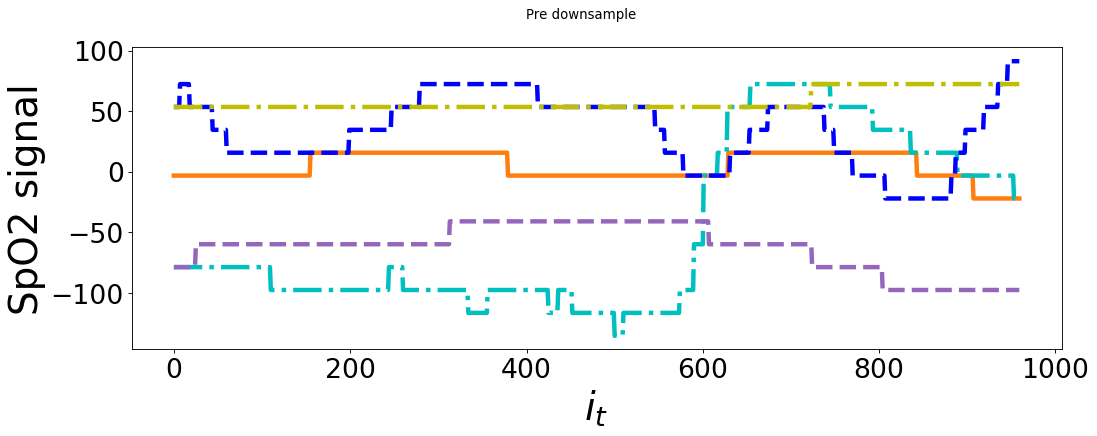

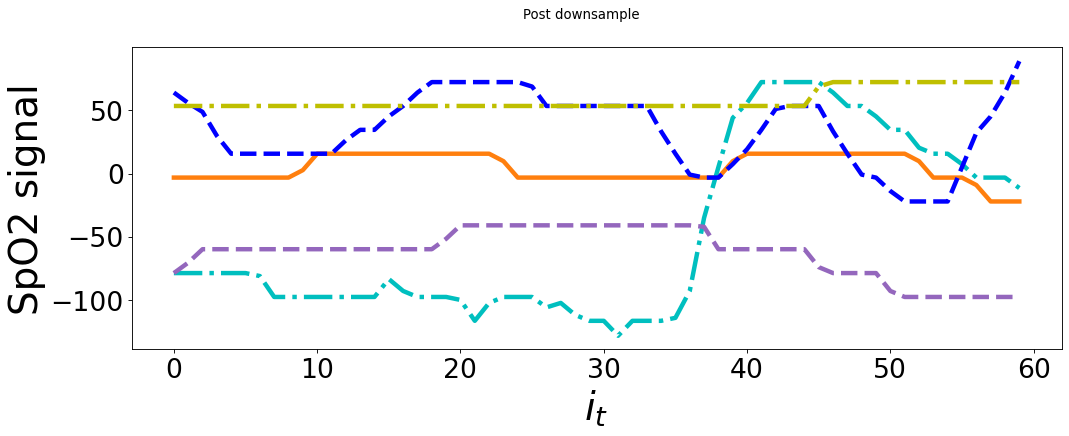

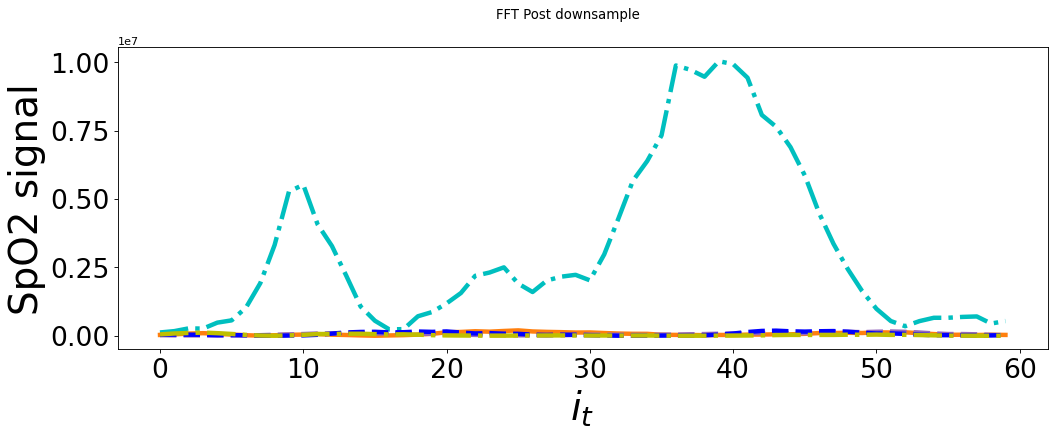

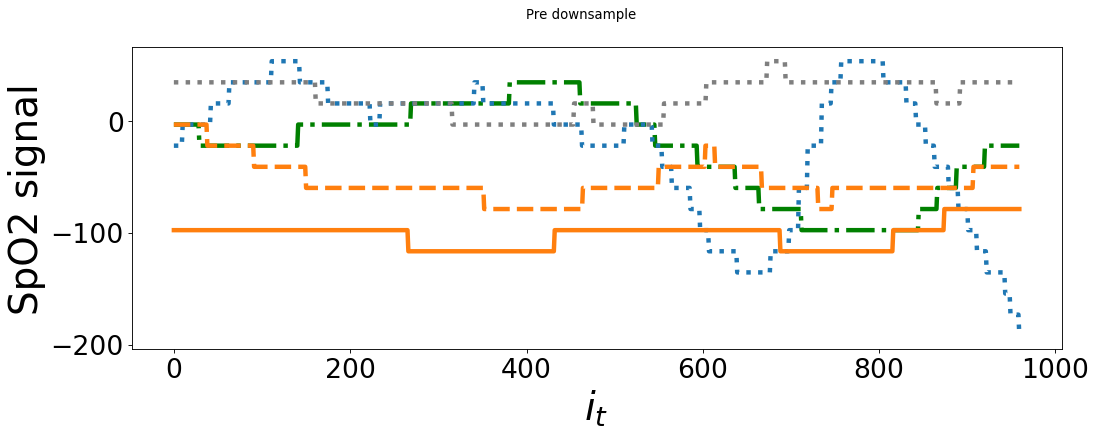

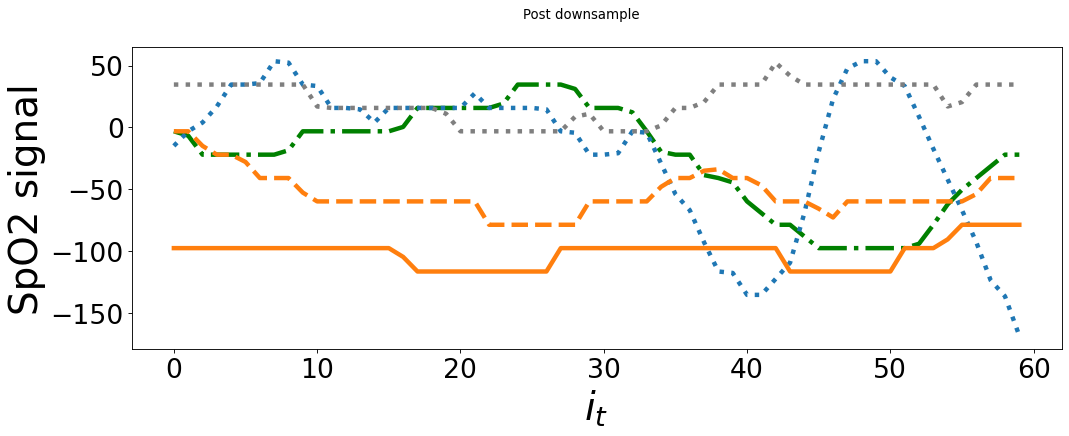

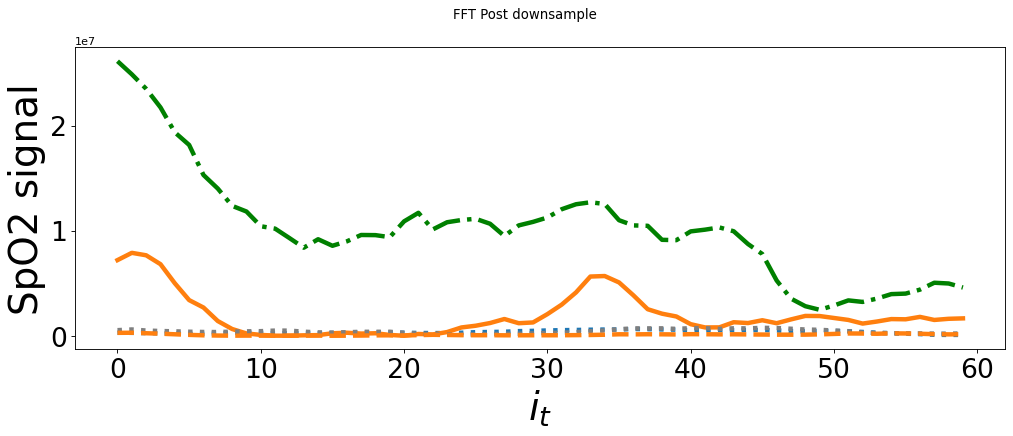

In [5]:
#trainDF=featured_tseries_df("train_SpO2seg.csv",downsample=4)
#valDF=featured_tseries_df("val_SpO2seg.csv",downsample=4)
#testDF=featured_tseries_df("test_SpO2seg.csv",downsample=4)
 

TSdsp1=TimeSeriesBundle("TSdsp1","../DatosOriginales/train_SpO2seg.csv","../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
            downsample=1,augment=1,diff=0)
TSdsp2=TimeSeriesBundle("TSdsp2","../DatosOriginales/train_SpO2seg.csv","../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
            downsample=2,augment=1,diff=0)
TSdsp4=TimeSeriesBundle("TSdsp4","../DatosOriginales/train_SpO2seg.csv","../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
            downsample=4,augment=1,diff=0)
TSdsp8=TimeSeriesBundle("TSdsp8","../DatosOriginales/train_SpO2seg.csv","../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
            downsample=8,augment=1,diff=0)
TSdsp16=TimeSeriesBundle("TSdsp16","../DatosOriginales/train_SpO2seg.csv","../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
            downsample=16,augment=1,diff=0)




In [6]:
import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import PredefinedSplit

In [7]:
class StandardDF_manual():
    def __init__(self,dfname,X_train,y_train,X_val,y_val,X_test,y_test,applyOHEy=False,\
                 skipcolsLs=None,applyscaler="colscaler",concatTrainVal=False):
    
        self.X_train=X_train
        self.y_train=y_train
        
        self.X_test=X_test
        self.y_test=y_test
        
        self.X_val=X_val
        self.y_val=y_val
        
        
        if concatTrainVal==True:
            self.make_sklearnTrainValIndexTuple() 
            self.X_trainval=np.concatenate((self.X_train,self.X_val),axis=0)
            self.y_trainval=np.concatenate((self.y_train,self.y_val),axis=0)
            
        ##################################
        
        ############ scaling ##############
        self.applyscaler=applyscaler
        if self.applyscaler=="colscaler":
            self.apply_scaler()
        elif self.applyscaler=="rowscaler":
            self.apply_rowscaler()
               
        self.make_sklearnTrainValIndexTuple()
        ############ balancing ############
        #self.make_balanced_DF()
    def make_sklearnTrainValIndexTuple(self):
        nrow_train=np.shape( self.X_train)[0]
        nrow_val=np.shape( self.X_val)[0]
        self.SKL_TrainValSplit=[-1]*nrow_train+ [0]*nrow_val
        
        self.ps = PredefinedSplit(self.SKL_TrainValSplit)
        self.ps.get_n_splits()
        
        #(np.arange(nrow_train) , \
        #       np.arange(nrow_train,nrow_train+nrow_val))
            
    def apply_rowscaler(self):
        ###################################
        self.sigmas=np.std( self.X_train ,axis=0)
        self.sigma=np.std(self.sigmas)
        self.means=np.mean(self.X_train,axis=0)
        self.mean=np.mean(self.means)
        ##################################
        self.X_train=self.X_train-self.mean###self.means[np.newaxis,:]
        self.X_train=self.X_train/self.sigma
        self.X_val=self.X_val-self.mean###self.means[np.newaxis,:]
        self.X_val=self.X_val/self.sigma
        self.X_test=self.X_test-self.mean###self.means[np.newaxis,:]
        self.X_test=self.X_test/self.sigma
        ############ subsampling #######################
        ## subsampling can be remade if necessary
        #self.make_subsample(self.SubsampFact)
        
        #print(self.X.describe())
        #print(self.y.describe())
    def apply_scaler(self):        
        trafo=make_column_transformer( (StandardScaler(),self.Xcols ))
        scaleTrain=trafo.fit_transform(self.X_train)
        scaledTest=trafo.transform(self.X_test)
        scaledVal=trafo.transform(self.X_val)
        #self.X = pd.DataFrame(self.X, columns = self.Xcols)
        #return scaledXmat

In [8]:
##(self,X,y,Xcols=None,ycols=None,skipcolsLs=None,applyscaler="scaler",balance=False,testsplit=0.2,subsampling=1)

# Puente entre clases
#TSdsp16.Train.df1
#TSdsp16.Val.df1
#TSdsp16.Test.df1
#DF01=StandardDF(TSdsp1.df0,TSdsp1.labelvec)
#DF16=StandardDF(TSdsp16.df1,TSdsp16.labelvec)

DF01=StandardDF_manual("DF01",TSdsp1.Train.df1,TSdsp1.Train.labelvec,\
                       TSdsp1.Val.df1,TSdsp1.Val.labelvec,\
                       TSdsp1.Test.df1,TSdsp1.Test.labelvec,\
                 skipcolsLs=None,applyscaler="rowscaler",concatTrainVal=True)

DF16=StandardDF_manual("DF16",TSdsp16.Train.df1,TSdsp16.Train.labelvec,\
                       TSdsp16.Val.df1,TSdsp16.Val.labelvec,\
                       TSdsp16.Test.df1,TSdsp16.Test.labelvec,\
                 skipcolsLs=None,applyscaler="rowscaler",concatTrainVal=True)

#StandardDF_manual("DF16",X_train,y_train,X_val,y_val,X_test,y_test,\
 #                skipcolsLs=None,applyscaler="rowscaler")
DFLs=[DF16]

Processing :  LinearSVC LinearSVC()
{'C': 0.1, 'tol': 0.001}
Processing :  RF RandomForestClassifier()
{'max_depth': 6, 'n_estimators': 150}
Processing :  MLP MLPClassifier()
{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (8,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Processing :  BAG BaggingClassifier(base_estimator=KNeighborsClassifier())
{'bootstrap': False, 'max_features': 4, 'n_estimators': 20}
Processing :  XGB XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tr

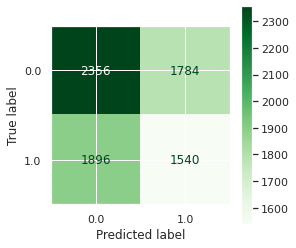

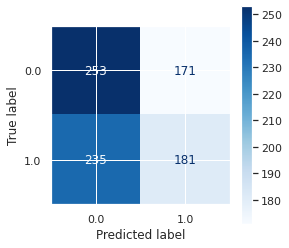

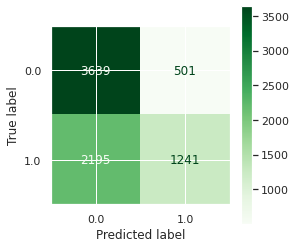

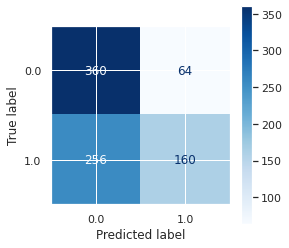

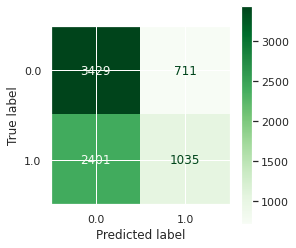

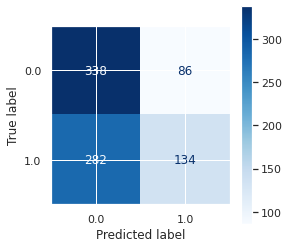

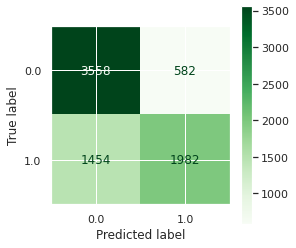

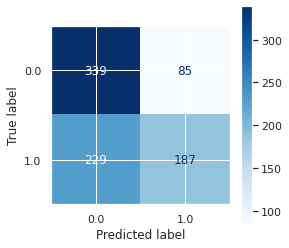

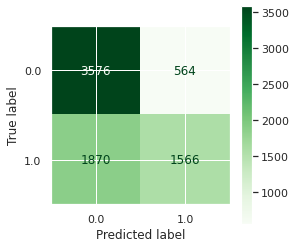

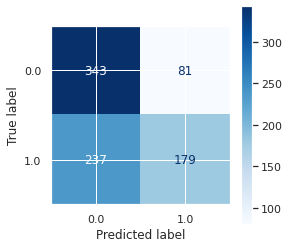

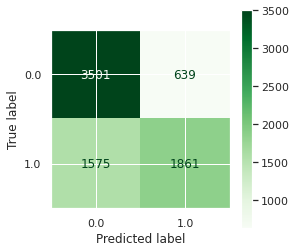

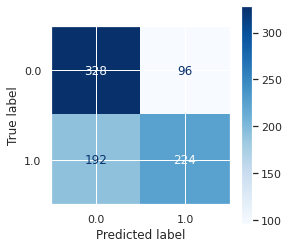

In [9]:
import warnings
warnings.filterwarnings('ignore')
from joblib import parallel_backend

from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

###Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier

# Ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier



from sklearn.model_selection import RepeatedStratifiedKFold,\
	 train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve,\
	 roc_auc_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
#import eli5
#from eli5.sklearn import PermutationImportance
from scipy.stats import ttest_rel  

from sklearn.model_selection import ParameterGrid
#from sklearn.metrics import r2_score
import sklearn.metrics as met


#from pandas_ml import ConfusionMatrix


import time
from matplotlib import pyplot


scoringDct = {"accuracy_score":"pred","roc_auc_score":"prob","roc_curve":"prob","precision_score":"pred",\
                "recall_score":"pred","confusion_matrix":"pred","precision_recall_curve":"prob"}#,"precission_recall_curve")#'neg_mean_squared_error'



pipeLs = []
sns.set(rc={"figure.figsize":(4, 4)})
ModelDct={
         "LinearSVC": LinearSVC(), \
         "RF":RandomForestClassifier() ,\
         "MLP": MLPClassifier(), \
     "BAG":BaggingClassifier(KNeighborsClassifier()),\
       "XGB":XGBClassifier(),\
    "LGB":LGBMClassifier(),\
}


GridDct={
         "LinearSVC": {"C":[0.01,0.1,1.0,10.0],"tol":[0.001]}, \
         "RF":{"n_estimators":[50,100,150],"max_depth":[2,5,6]} ,\
         "MLP":{"hidden_layer_sizes":[(1,),(2,),(4,),(6,),(6,),(8,),(10,),(15,),\
                    (20,),(25,),(30,),(40,),(50,),(100,)],"activation":["relu"],\
                "alpha":[0.0001,0.001,0.1,1.0,10.0],"learning_rate":["adaptive"],\
                "solver":["adam"]},\
            "XGB":{"learning_rate":[0.01,0.05,0.1,1.0,3.0],"max_depth":[4,5,6]},\
            "LGB":{"boosting_type":["gbdt","dart","rf"]},\
    "BAG":{"bootstrap":[True,False],"max_features":[2,4,8],"n_estimators":[10,20]},\
}


names=[]
PredDict={}
timings={}

#We gather the scorings from each method.
CVResu={}
BigChartTra={"names":[],"time":[],"ngrid":[],"confmat":[],"plots_confmat":[],"feat_imp":[]}
BigChartTe={"names":[],"time":[],"ngrid":[],"confmat":[],"plots_confmat":[],"feat_imp":[]}
BestParsDct={}

for key in scoringDct.keys():
    BigChartTra[key]=[]#
    BigChartTe[key]=[]#

#YpredTest=
YpredTrain={}
YpredTest={}

## Option to run the computationally intensive methods from the dict:
HeavyCatalog=["SVC","MLP","LinearSVC"]
runheavy=True


# More complex function, that tries to generate the probability or scoring.            
def make_scoring2(CollectDct,model,scoreDct,Xint,ytrue,cla_reg="cla"):
    import sklearn.metrics as met
    functions_to_try=["predict","predict_proba","decision_function"]
    if cla_reg=="cla":
        ### 
        modelPreScorers={}
        for funtry in functions_to_try:
            xsco=Xint
            if hasattr(model, funtry):
                ysco=getattr(model,funtry)(xsco)                            
            else:
                continue                
            if funtry=="predict_proba":
                modelPreScorers[funtry]= ysco[:,1]  
            else :
                modelPreScorers[funtry]= ysco  
        
        
        for sco,prob_pred in scoreDct.items(): #
            if prob_pred=="pred":
                yscofun=modelPreScorers["predict"]
                if hasattr(met,sco):
                    CollectDct[sco].append( getattr(met,sco)(ytrue,yscofun) )
                else :
                    CollectDct[sco].append( np.nan )
            
            if prob_pred=="prob":
                for funtry in functions_to_try[1:]:
                    if hasattr(model, funtry):
                        yscofun=modelPreScorers[funtry]
                        CollectDct[sco].append( getattr(met,sco)(ytrue,yscofun) )
                        break
                    #if hasattr(met,sco):
                    
                    
            
def dct_to_string(dct):
    str0=""
    for key,val in dct.items():
        str0=str(key)+" : "+str(val)+" ; "
    return str0
num_folds = 10
seed = 203
### Utilizamos la libreria joblib, que permite paralelizar 
### internamente los procedimientos de scikit learn
for DF in DFLs:
    with parallel_backend('threading', n_jobs=8):
        #for name, model in pipeLs:
        for name, mod in ModelDct.items():


            ####
            dfObj=DF

            if runheavy==False:
                if name in HeavyCatalog:
                    continue

            ngrid=1
            for val in GridDct[name].values():
                ngrid*=len(val)

            print("Processing : ", name, mod)
            t0=time.time()
            simu=GridSearchCV( mod,GridDct[name],cv=dfObj.ps,return_train_score=True, \
                              scoring="roc_auc")

            #simu.fit(dfObj.X_tra, dfObj.y_tra)
            simu.fit(dfObj.X_trainval, dfObj.y_trainval)
            
            print(simu.best_params_)
            bestpar=dct_to_string(simu.best_params_)
            BestParsDct[name]=bestpar

            #ypre=simu.best_estimator_.predict(dfObj.X_tra)
            ypre=simu.best_estimator_.predict(dfObj.X_trainval)

            t1=time.time()
            names.append(name)

            #ypreTe=simu.best_estimator_.predict(dfObj.X_te)
            ypreTe=simu.best_estimator_.predict(dfObj.X_test)



            YpredTrain[name]=ypre
            YpredTest[name]=ypreTe
            ###############################################
            BigChartTra["names"].append(name)
            #BigChartTra["every"].append(dfObj.SubsampFact)
            BigChartTra["time"].append( t1-t0 )        
            BigChartTra["ngrid"].append(ngrid)
            #BigChartTra["plots_confmat"].append( plot_confusion_matrix(simu.best_estimator_, \
            #                    dfObj.X_tra, dfObj.y_tra,cmap="Greens") )
            
            BigChartTra["confmat"].append(  confusion_matrix(dfObj.y_trainval , ypre ) )# ConfusionMatrix(dfObj.y_trainval , ypre) )#
            BigChartTra["plots_confmat"].append( plot_confusion_matrix(simu.best_estimator_, \
                                dfObj.X_trainval, dfObj.y_trainval,cmap="Greens") )
            
            if hasattr(simu.best_estimator_,"feature_importances_")==True:
                BigChartTra["feat_imp"].append(simu.best_estimator_.feature_importances_)
            else:
                BigChartTra["feat_imp"].append(np.nan)
            #make_scoring(BigChartTra,scoringDct, MainDF.y_tra, ypre,ydeci,cla_reg="cla")
            #make_scoring2(BigChartTra,simu,scoringDct,dfObj.X_tra,dfObj.y_tra,cla_reg="cla")
            make_scoring2(BigChartTra,simu,scoringDct,dfObj.X_trainval,dfObj.y_trainval,cla_reg="cla")
            ################################################
            BigChartTe["names"].append(name)
            #BigChartTe["every"].append(dfObj.SubsampFact)
            BigChartTe["time"].append( t1-t0 )
            BigChartTe["ngrid"].append(ngrid)
            
            BigChartTe["confmat"].append(confusion_matrix(dfObj.y_test , ypreTe ) )# ConfusionMatrix(dfObj.y_test , ypreTe) )#pd.crosstab(ypreTe, dfObj.y_test ).to_numpy() )
            BigChartTe["plots_confmat"].append( plot_confusion_matrix(simu.best_estimator_, dfObj.X_test,\
                                            dfObj.y_test,cmap="Blues") )
            if hasattr(simu.best_estimator_,"feature_importances_")==True:
                BigChartTe["feat_imp"].append(simu.best_estimator_.feature_importances_)
            else:
                BigChartTe["feat_imp"].append(np.nan)
            #make_scoring(BigChartTe,scoringDct, MainDF.y_te, ypreTe,ydeciTe,cla_reg="cla")
            make_scoring2(BigChartTe,simu,scoringDct,dfObj.X_test,dfObj.y_test,cla_reg="cla")
            #################################################
            
            CVResu[name]=simu.cv_results_# ); CVResu["names"].append(name)
            
            #################################################

TRAINING
TESTING


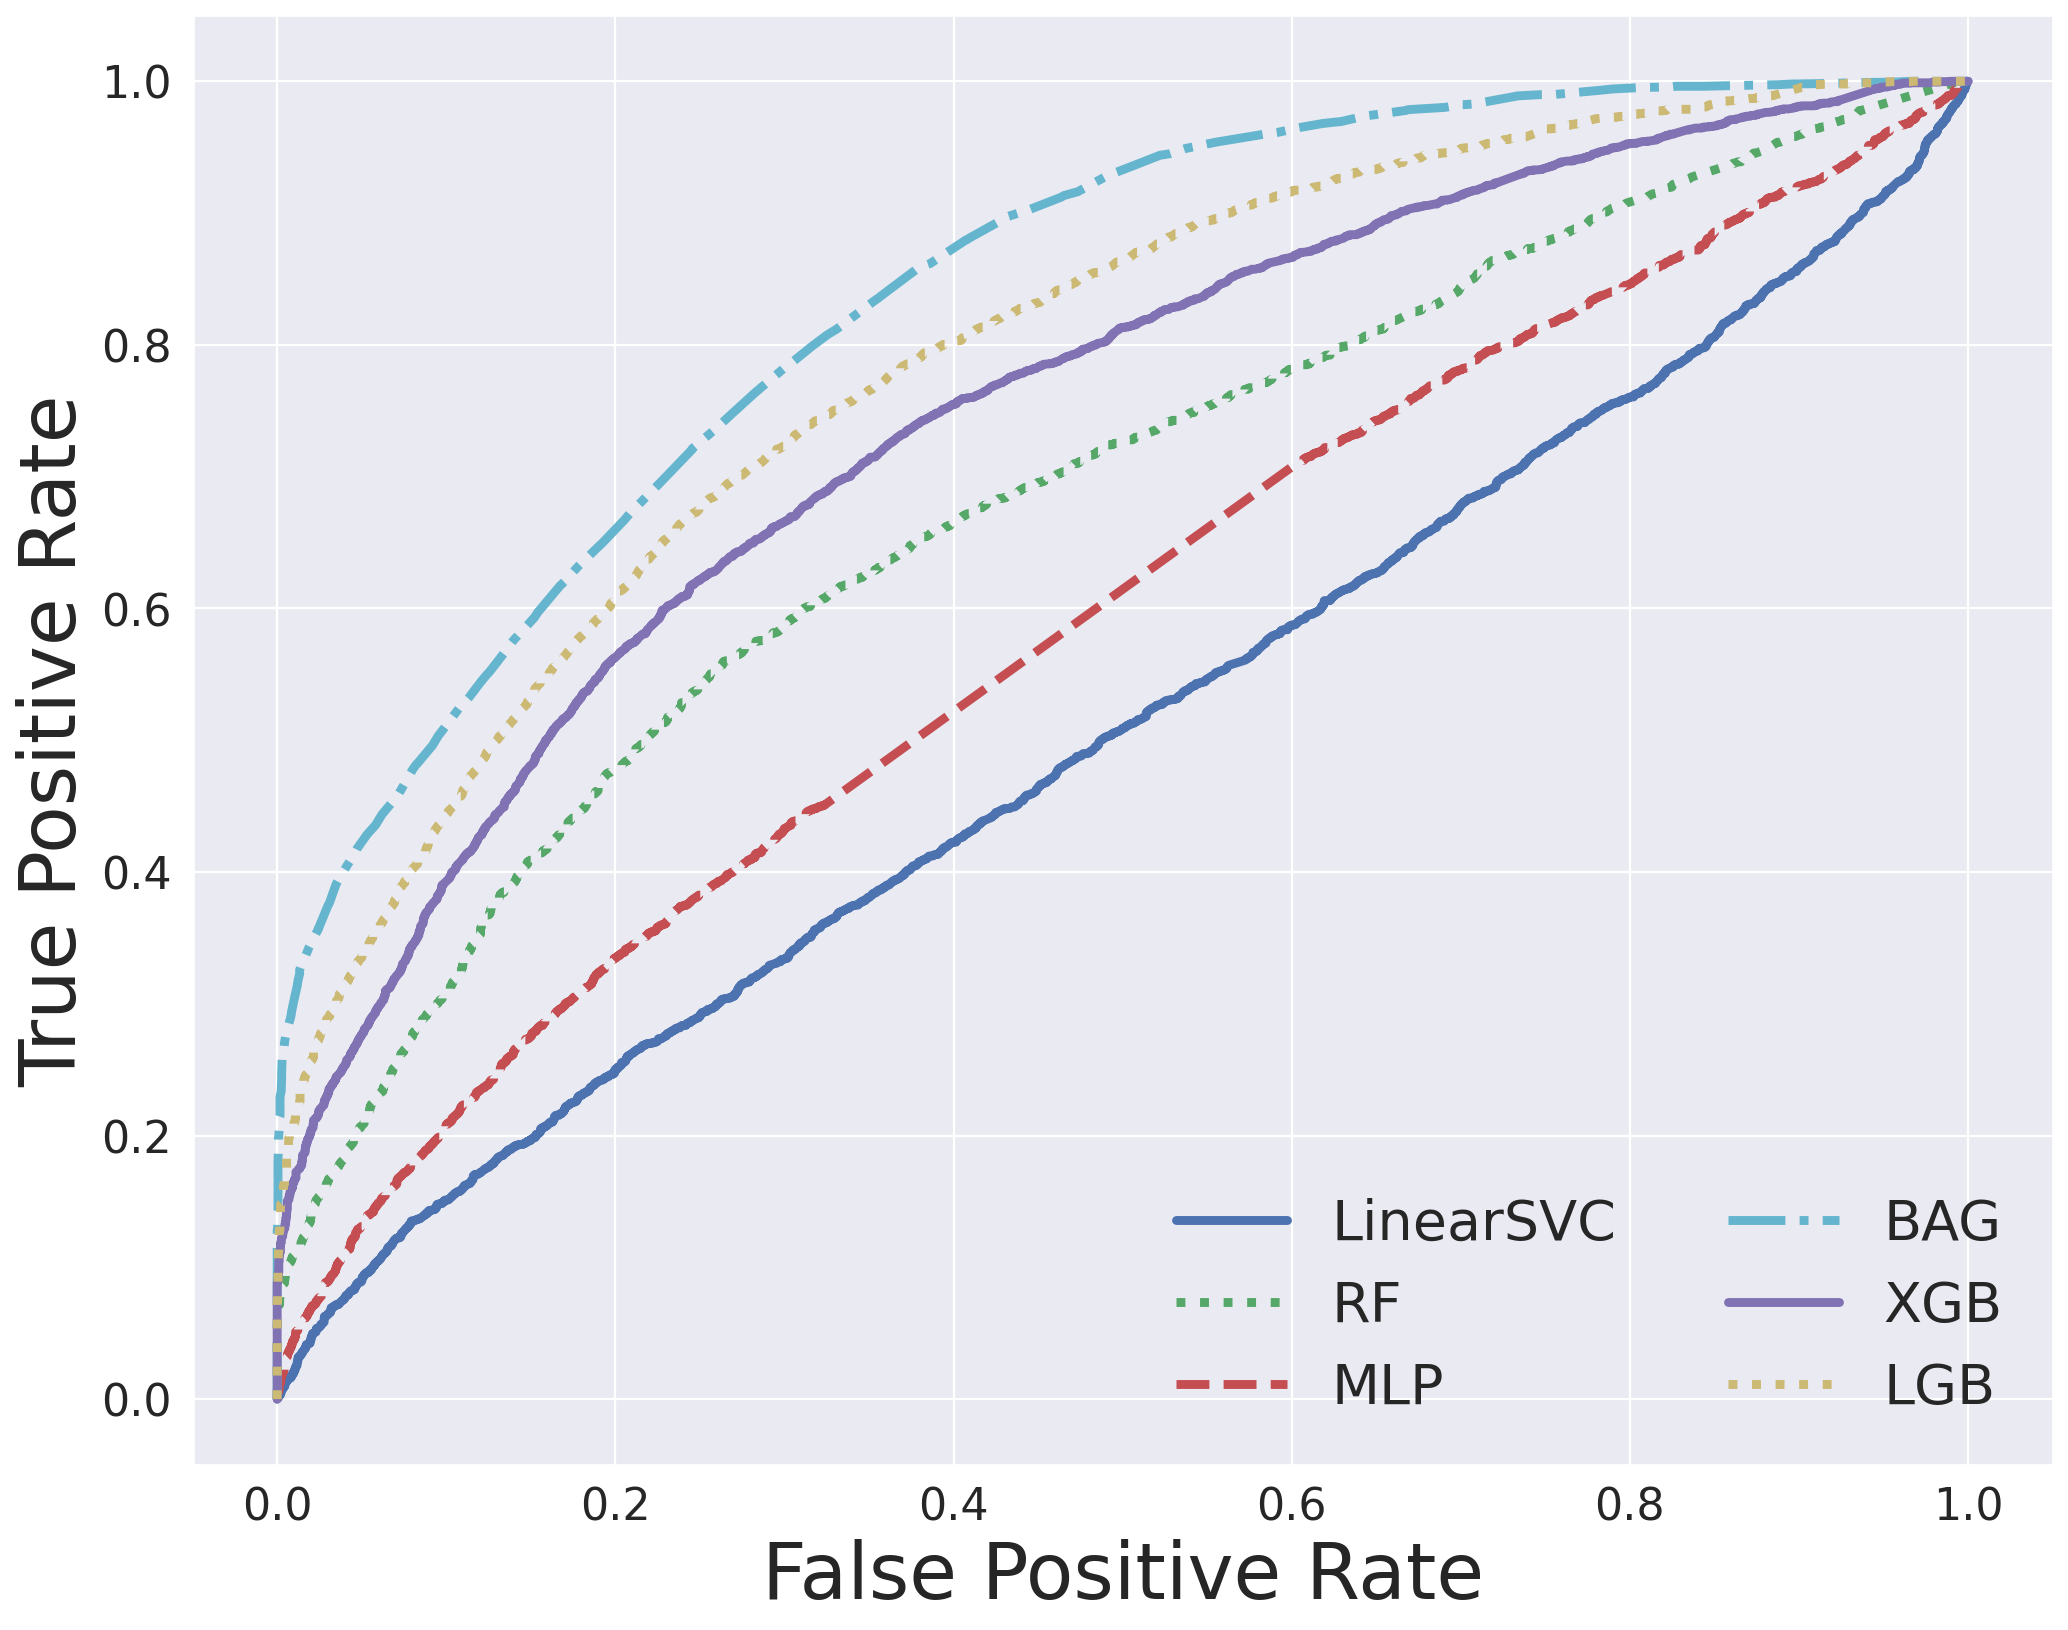

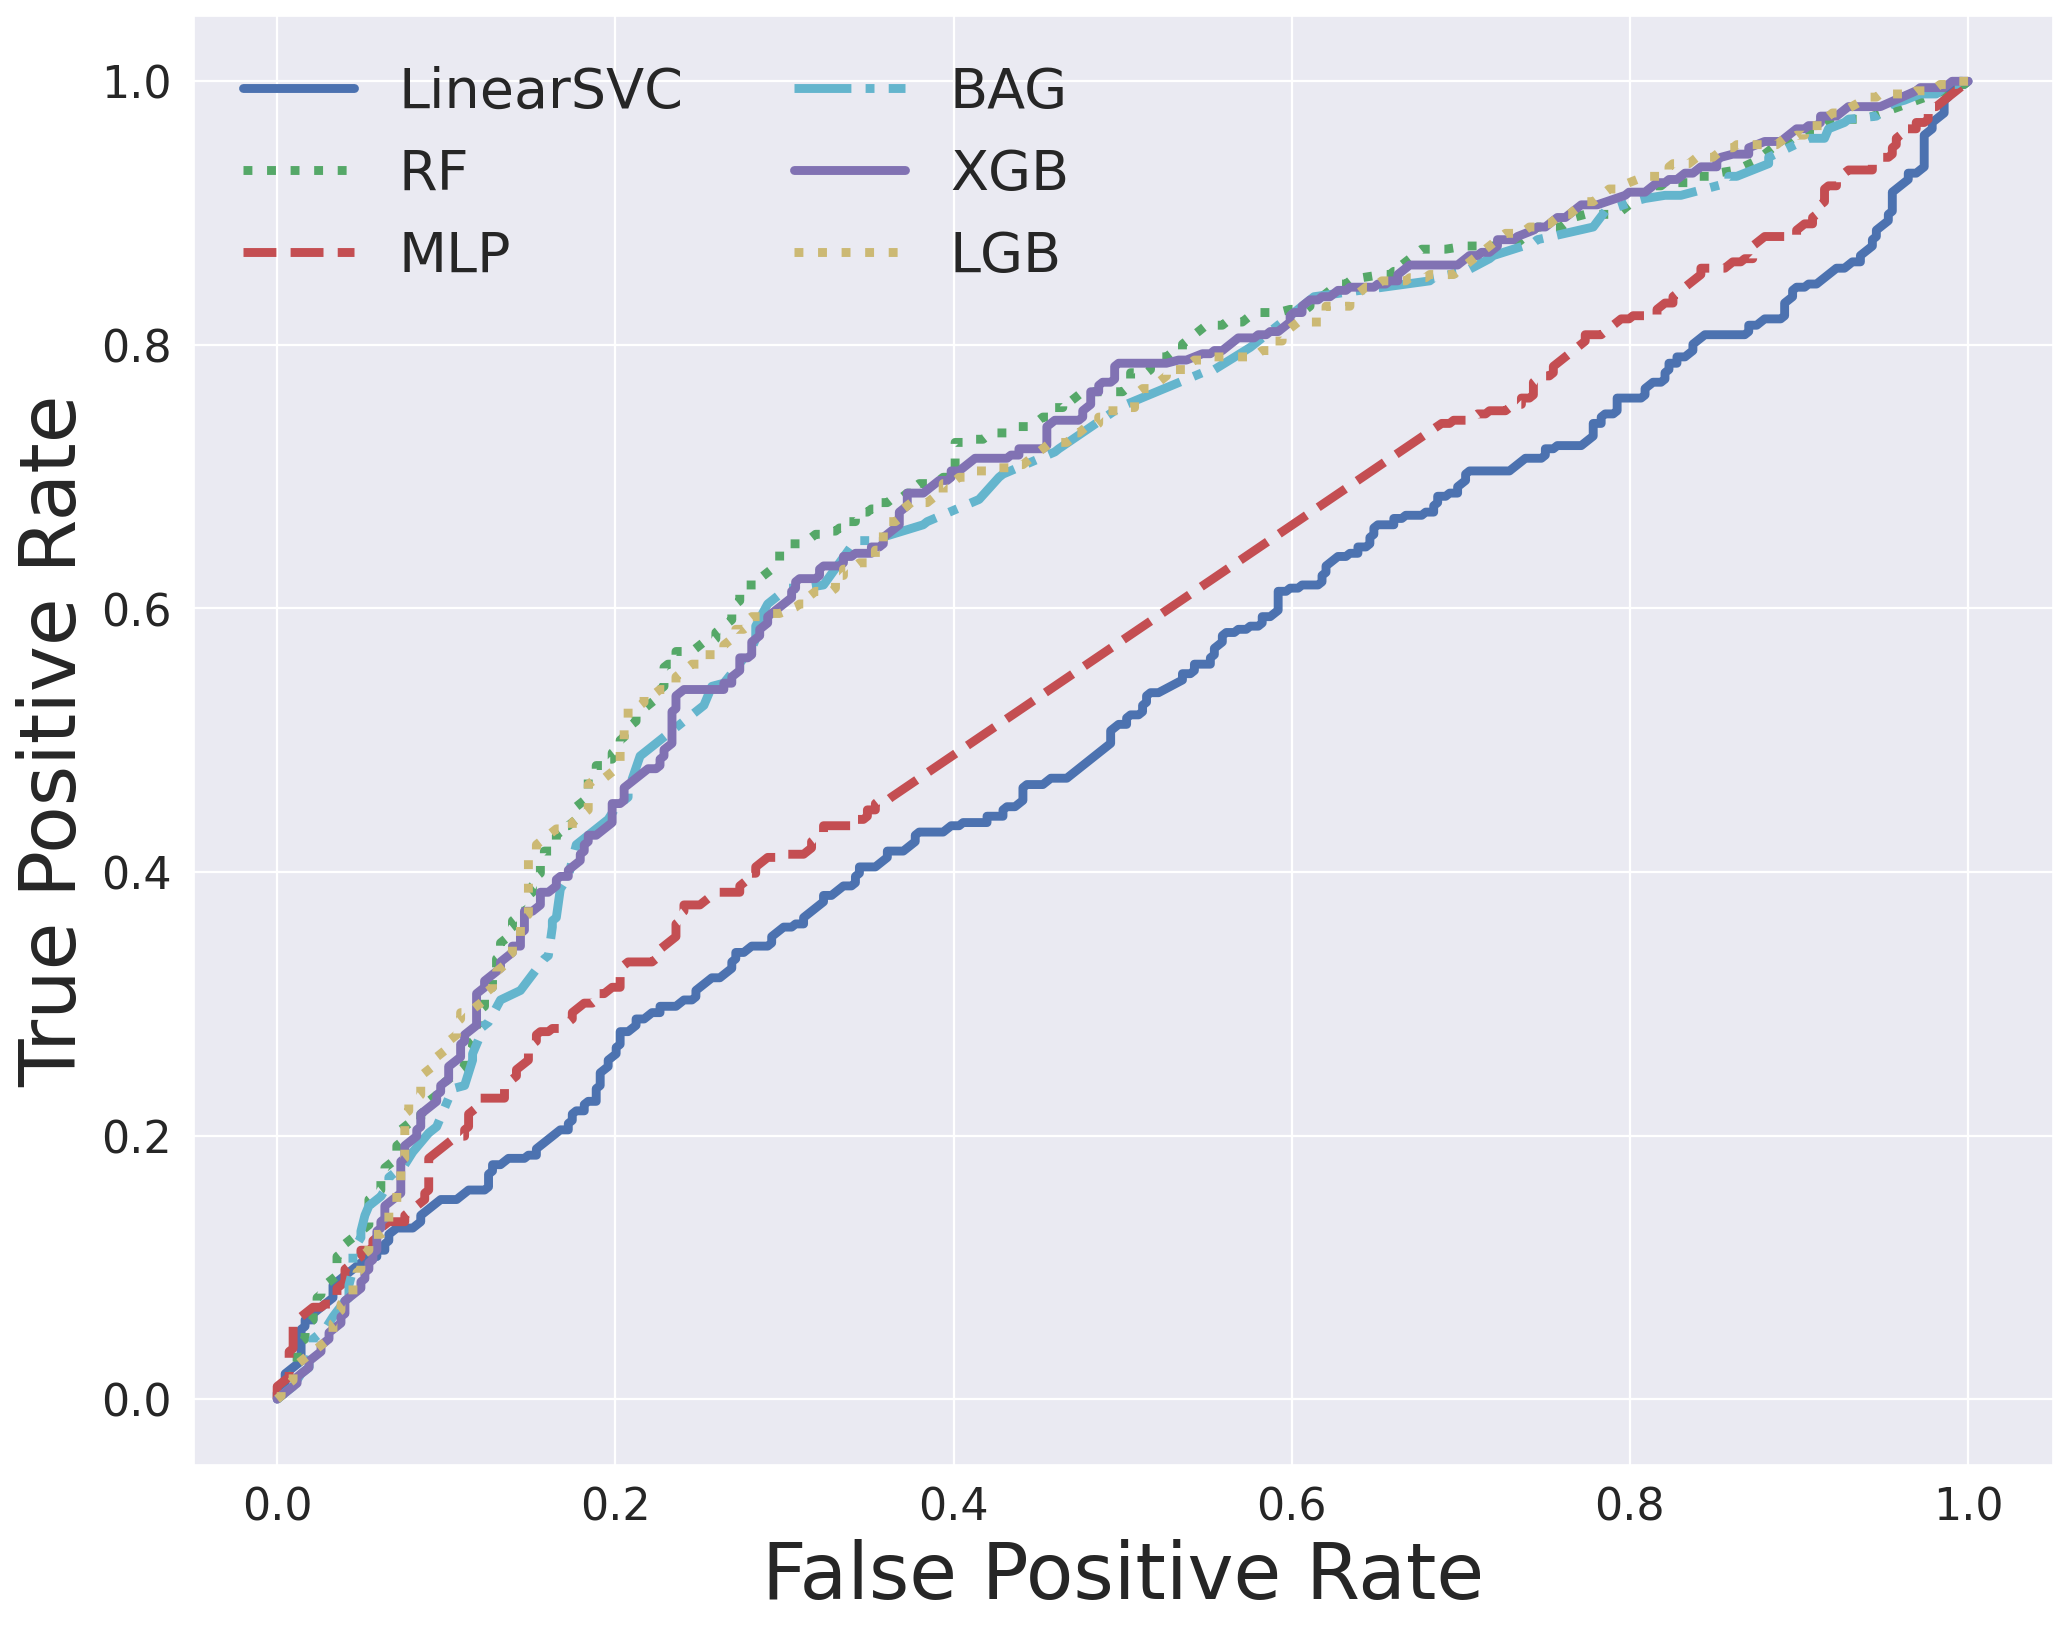

names  roc_auc_score  ngrid
1         RF       0.695624      9
5        LGB       0.686644      3
4        XGB       0.683701     15
3        BAG       0.674914     12
2        MLP       0.562058     70
0  LinearSVC       0.511135      4

names  time_per_run  ngrid
2        MLP      2.511007     70
0  LinearSVC      0.842546      4
1         RF      0.354269      9
3        BAG      0.329647     12
4        XGB      0.294938     15
5        LGB      0.255979      3

names  ngrid  roc_auc_score  roc_auc_score_Te  overfit_rating  \
1         RF      9       0.682641          0.695624        0.689072   
5        LGB      3       0.789835          0.686644        0.734633   
4        XGB     15       0.748997          0.683701        0.714861   
3        BAG     12       0.836601          0.674914        0.747110   
2        MLP     70       0.588379          0.562058        0.574917   
0  LinearSVC      4       0.505192          0.511135        0.508146   

   overfit_rating2  
1        -0.018840  
5         0.139780  
4         0.091151  
3         0.213941  
2         0.045759  
0        -0.011695

LinearSVC tol : 0.001 ; 
RF n_estimators : 150 ; 
MLP solver : adam ; 
BAG n_estimators : 20 ; 
XGB max_depth : 5 ; 
LGB boosting_type : dart ; 


In [14]:

from IPython.display import display

DFTra=pd.DataFrame(BigChartTra)
DFTe=pd.DataFrame(BigChartTe)
DFTra["time_per_run"]=DFTra["time"]/DFTra["ngrid"]
DFTe["time_per_run"]=DFTe["time"]/DFTe["ngrid"]

print("TRAINING")
#display(DFTra)
print("TESTING")
#display(DFTe)



def show_roc(DF):
    
    linestyle_str = ["-",":","--","-."]
    linewidth=[4]
    linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
    nwidths=len(linewidth)
    nstyles=len(linestyle_str)
    ncolor=len(linecol)
    fig = plt.figure(figsize=(15.0, 12.0), dpi=160)
    plt.clf()
    ax1 = fig.add_subplot(1,1,1)
    ax1.tick_params("both",labelsize=20)
    ax1.set_xlabel('False Positive Rate', fontsize = 35)
    ax1.set_ylabel('True Positive Rate', fontsize = 35)
    for il,line in enumerate(DF["roc_curve"]):
        #print(np.shape(line))

        #DFTe.iloc[il,"roc_curve"]
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(line[0],line[1],lw=linewidth[il%nwidths],linestyle=linestyle_str[il%nstyles],\
                 color=linecol[il%ncolor])
        #plt.savefig(strname ,bbox_inches='tight', transparent=False)
        ##fig.delaxes(ax)
        #leg1=ax1.legend(fontsize = 35,frameon=False, loc=2,ncol=2)
        leg1=ax1.legend(fontsize = 25,frameon=False, loc=0,ncol=2,labels=list(DF["names"]))
    plt.show()

def show_confmat(DF):
    #fig,ax =  plt.subplots(figsize=(15.0, 12.0), dpi=160)
    #ax1 = fig.add_subplot(1,1,1)
    for index, row in DF.iterrows():
        print(row["names"])
        row["plots_confmat"].plot()
        
        #plt.show()
        
        
show_roc(DFTra)
show_roc(DFTe)


#show_confmat(DFTra)
#show_confmat(DFTe)

##X=pd.concat([DBNum,DBFact],axis=1)
display(DFTe[["names","roc_auc_score","ngrid"]].sort_values(by="roc_auc_score",ascending=False))

display(DFTe[["names","time_per_run","ngrid"]].sort_values(by="time_per_run",ascending=False))

def overfitting_rating(aucTra,aucTe):
    rat=2.0*aucTra*aucTe/(aucTe+aucTra)
    return rat
    
DFauc=DFTra[["names","ngrid","roc_auc_score"]].copy(deep=True)
#print(DFauc.head())
DFauc=DFauc.join(DFTe["roc_auc_score"],how="left",lsuffix="",rsuffix=("_Te"))
#print(DFauc.head())
DFauc["overfit_rating"]=2.0*(DFauc["roc_auc_score"]*DFauc["roc_auc_score_Te"])/(DFauc["roc_auc_score"]+DFauc["roc_auc_score_Te"] )
DFauc["overfit_rating2"]=2.0*(DFauc["roc_auc_score"]-DFauc["roc_auc_score_Te"])/(DFauc["roc_auc_score"]+DFauc["roc_auc_score_Te"] )
display(DFauc.sort_values(by="roc_auc_score_Te",ascending=False))


for name,BP in BestParsDct.items():
    print(name,BP)


    

In [11]:
CVResu["MLP"]



{'mean_fit_time': array([10.56413746,  9.29206204, 23.36744928, 15.65793872, 21.36616039,
        19.07371879, 24.06456041, 33.35780001, 21.75494313, 34.7254591 ,
        11.12449598, 19.07259512, 29.2258873 , 27.51868939,  5.27460361,
        10.78576255, 21.08752084, 19.90572214, 16.07240248, 13.04283834,
        18.3731451 , 16.53599453, 26.13273025, 26.48863435, 21.57129502,
        23.87369871, 36.84188032, 21.36607909,  3.68853235, 10.8190248 ,
        22.85597825, 12.49241304, 17.48976398, 16.68503594, 13.40749288,
        18.50090384, 25.20947909, 23.1806314 , 27.02085757, 16.2582221 ,
        14.83218884, 33.65726304,  5.70873332, 13.42572308, 14.07496119,
        11.96481824, 13.55643177, 18.10835862, 15.9334271 , 21.0257225 ,
        13.85219955, 42.92837834, 23.92328572, 13.06108499, 11.95678377,
        12.96883988, 10.90488052, 15.60159659, 13.35179687, 18.44662142,
        26.68046236, 20.24230242, 24.2085278 , 25.45496225, 27.83191419,
        24.37814403, 22.12251115, 

In [16]:
import operator
from functools import reduce

Alpha=np.log10( list( CVResu["MLP"]["param_alpha"]  ) )
HL=list(reduce(operator.concat,  CVResu["MLP"]["param_hidden_layer_sizes"]  ))
Score=CVResu["MLP"]["mean_train_score"]

#np.log(Alpha)
                    
print(Alpha)
print(HL)
print(Score)#CVResu["MLP"]["mean_train_score"]
iSc=np.argmax(Score)
print( Alpha[iSc],HL[iSc],Score[iSc])

[-4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[1, 2, 4, 6, 6, 8, 10, 15, 20, 25, 30, 40, 50, 100, 1, 2, 4, 6, 6, 8, 10, 15, 20, 25, 30, 40, 50, 100, 1, 2, 4, 6, 6, 8, 10, 15, 20, 25, 30, 40, 50, 100, 1, 2, 4, 6, 6, 8, 10, 15, 20, 25, 30, 40, 50, 100, 1, 2, 4, 6, 6, 8, 10, 15, 20, 25, 30, 40, 50, 100]
[0.56174777 0.55454176 0.6166341  0.55473202 0.53114918 0.55024302
 0.63997906 0.61508294 0.6252352  0.67032511 0.59913875 0.61950991
 0.63741748 0.67961909 0.50653005 0.55617778 0.60855219 0.5681311
 0.57315411 0.55864166 0.62264099 0.61335384 0.64178497 0.6234482
 0.6074115  0.67818151 0.66623292 0.68147023 0.53979615 0.54514238
 0.64286134 0.53440347 0.66156136 0.6501633  0.58571942 0.62950739
 0.6309996  0.65404165 0.60195216 0.62291979 0.63480996 0.6

0.687930130871841


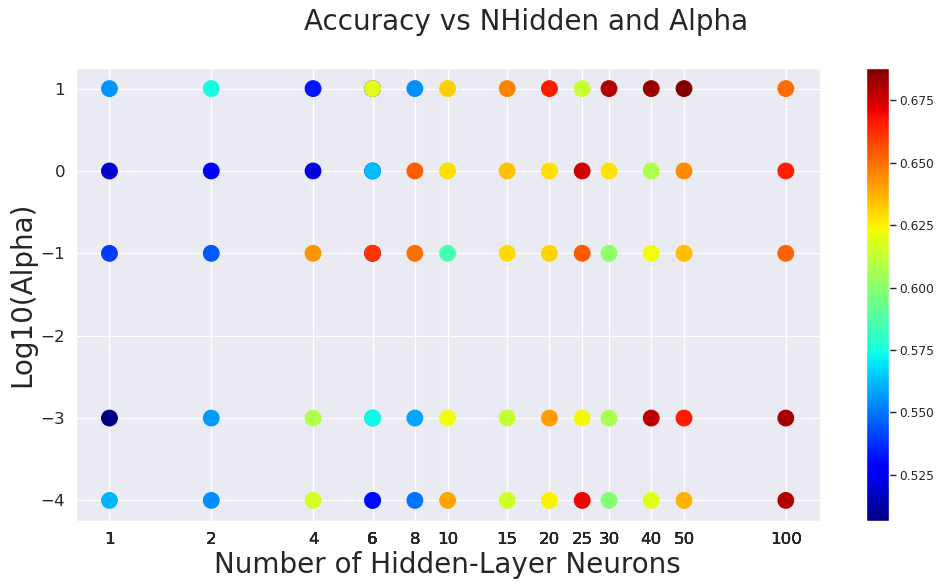

In [17]:
#import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(15, 7.5), dpi=80)
ax = plt.gca()

cmpalette=plt.cm.jet#plt.cm.jet
img=ax.scatter(HL,Alpha, s=200, c=Score, cmap=cmpalette) 

#ax.xlabel('Number of Hidden Layers', fontsize=20)
ax.set_xscale('log')
ax.set_xlabel("Number of Hidden-Layer Neurons", fontsize = 25)
ax.set_ylabel("Log10(Alpha)", fontsize = 25)
ax.tick_params("both",labelsize=15)
#ax.ylabel('Log10(Alpha)', fontsize=20)
ax.set_xticks(HL)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.suptitle('Accuracy vs NHidden and Alpha', fontsize=25)
fig.colorbar(img)
print(np.amax(Score))
#plt.colorbar(img, ax=ax)